# local da bagunca

In [1]:
import os
import warnings
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
import random
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer
import geopandas as gpd
from sklearn.metrics import r2_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

In [2]:
# Reseta para o padrão (Branco)
plt.style.use('default')

# Ou força o estilo Seaborn com fundo branco e grid
sns.set_theme(style="whitegrid")

# Garante que o fundo das figuras salvas seja branco
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

import matplotlib.pyplot as plt

# 1. Força o backend do notebook a usar fundo branco, ignorando o tema do editor
%config InlineBackend.print_figure_kwargs = {'facecolor' : "white", 'bbox_inches': 'tight'}

# 2. Define globalmente no Matplotlib
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.transparent'] = False  # <--- O segredo: desativar transparência

In [3]:
# Configurações de exibição
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

# ==========================================
# 1. CONFIGURAÇÕES E CAMINHOS
# ==========================================
# Ajuste conforme seu ambiente (Colab ou Kaggle)
# Se for Colab:
DATA_PATH = "../data/processed/dataset_tft_completo.parquet"
CHECKPOINT_DIR = "../src/models/checkpoints"

# Se for Kaggle (descomente abaixo):
# DATA_PATH = "/kaggle/input/dengue-dataset/dataset_tft_completo.parquet" # Ou /kaggle/working/...
# CHECKPOINT_DIR = "/kaggle/working/models/checkpoints/"

BATCH_SIZE = 64

# --- Definição das Variáveis (Deve ser IGUAL ao treino) ---
TARGETS = ["R0", "peak_week", "log_total_cases", "alpha", "beta"]

TIME_VARYING_KNOWN_REALS = [
    "time_idx", "week_cycle", "sin_week_cycle", "cos_week_cycle", "log_pop",
    "forecast_temp_med", "forecast_precip_tot"
]

TIME_VARYING_UNKNOWN_REALS = [
    "casos", "incidence",
    "temp_med", "precip_med", "rel_humid_med",
    "enso", "iod",
    "tda_entropy_H1", "tda_amplitude_H1"
]

STATIC_CATEGORICALS = ["uf", "koppen", "biome", "macroregion_name"]
STATIC_REALS = ["num_neighbors"]

# ==========================================
# 2. FUNÇÕES DE CARREGAMENTO
# ==========================================
def load_data():
    print(f"⏳ Carregando dados de: {DATA_PATH}")
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Arquivo não encontrado: {DATA_PATH}")

    data = pd.read_parquet(DATA_PATH)

    # Garantir Tipos
    data["time_idx"] = data["time_idx"].astype(int)
    data["geocode"] = data["geocode"].astype(str)
    for col in STATIC_CATEGORICALS:
        if col in data.columns:
            data[col] = data[col].astype(str)

    # Limpeza de NaNs (Crítico para inferência)
    cols_check = TARGETS + TIME_VARYING_UNKNOWN_REALS + TIME_VARYING_KNOWN_REALS
    cols_check = [c for c in cols_check if c in data.columns]
    data = data.dropna(subset=cols_check)

    print(f"✅ Dados carregados. Total linhas: {len(data)}")
    return data

def get_best_checkpoint():
    # Encontra o arquivo .ckpt mais recente na pasta
    if not os.path.exists(CHECKPOINT_DIR):
        raise FileNotFoundError(f"Pasta de checkpoints não encontrada: {CHECKPOINT_DIR}")

    checkpoints = [os.path.join(CHECKPOINT_DIR, f) for f in os.listdir(CHECKPOINT_DIR) if f.endswith(".ckpt")]
    if not checkpoints:
        raise FileNotFoundError("Nenhum arquivo .ckpt encontrado na pasta!")

    latest_ckpt = max(checkpoints, key=os.path.getctime)
    print(f"🏆 Checkpoint selecionado: {latest_ckpt}")
    return latest_ckpt

# ==========================================
# 3. PREPARAÇÃO DO DATALOADER
# ==========================================
def prepare_dataloader(data):
    print("🛠️ Recriando TimeSeriesDataSet (Validação)...")

    # Definir corte de tempo (Último ano para teste)
    max_prediction_length = 1
    max_encoder_length = 52
    training_cutoff = data["time_idx"].max() - max_prediction_length

    # Normalizadores (Iguais ao treino)
    target_normalizer = MultiNormalizer([
        GroupNormalizer(groups=["geocode"], transformation="softplus"), # R0
        GroupNormalizer(groups=["geocode"], transformation="softplus"), # peak_week
        GroupNormalizer(groups=["geocode"], transformation=None),       # log_total_cases
        GroupNormalizer(groups=["geocode"], transformation="logit"),    # alpha
        GroupNormalizer(groups=["geocode"], transformation="softplus")  # beta
    ])

    # 1. Recriar o Dataset de Treino (apenas a estrutura, para ajustar os encoders)
    # Isso é necessário para que o modelo saiba como transformar os dados novos igual aos antigos
    training_dataset = TimeSeriesDataSet(
        data[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target=TARGETS,
        group_ids=["geocode"],
        min_encoder_length=20,
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=STATIC_CATEGORICALS,
        static_reals=STATIC_REALS,
        time_varying_known_reals=TIME_VARYING_KNOWN_REALS,
        time_varying_unknown_reals=TIME_VARYING_UNKNOWN_REALS,
        allow_missing_timesteps=True,
        target_normalizer=target_normalizer,
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    # 2. Criar Dataset de Validação (Onde faremos o teste)
    validation = TimeSeriesDataSet.from_dataset(
        training_dataset,
        data,
        predict=True,
        stop_randomization=True
    )

    dataloader = validation.to_dataloader(
        train=False,
        batch_size=BATCH_SIZE * 2,
        num_workers=0 # Use 2 no Colab/Linux, 0 no Windows
    )

    return dataloader

# ==========================================
# 4. FUNÇÕES DE MÉTRICAS E PLOT
# ==========================================
def richards_curve_diff(t, L, t_peak, alpha, beta):
    """Reconstrói a curva de incidência (novos casos)."""
    t = np.array(t)
    b = beta * alpha
    c = 1
    exponent = np.clip(b * (t - t_peak), -50, 50)
    denom = (1 + c * np.exp(exponent))
    J_t = L * (denom ** (-1 / alpha))
    incidence = np.diff(J_t, prepend=J_t[0])
    return incidence

def evaluate_model(model, dataloader):
    print("🔮 Gerando previsões (Inference)...")

    # Previsão
    raw_predictions = model.predict(dataloader, mode="prediction", return_x=True, return_y=True)
    preds = raw_predictions.output
    targets = raw_predictions.y

    print("\n📊 MÉTRICAS POR TARGET:")
    results = []

    for i, name in enumerate(TARGETS):
        y_pred = preds[i].cpu().numpy().flatten()
        y_true = targets[0][i].cpu().numpy().flatten()

        # Desfazer Log do Total Cases
        if "log_total_cases" in name:
            y_pred = np.expm1(y_pred)
            y_true = np.expm1(y_true)
            metric_name = "Total Cases (Real Scale)"
        else:
            metric_name = name

        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        print(f"  🔹 {metric_name:<25} | MAE: {mae:.4f} | R²: {r2:.4f}")
        results.append((y_pred, y_true))

    return preds, targets, raw_predictions.x

def plot_random_examples(preds, targets, x_data, n=3):
    print(f"\n📸 Gerando {n} reconstruções de curva aleatórias...")

    total_samples = len(preds[0])
    indices = random.sample(range(total_samples), n)

    weeks = np.arange(1, 53)

    for idx in indices:
        # Extrair parâmetros previstos e reais
        # Índices em TARGETS: 0:R0, 1:Peak, 2:LogTotal, 3:Alpha, 4:Beta
        p_R0 = preds[0][idx].item()
        p_peak = preds[1][idx].item()
        p_L = np.expm1(preds[2][idx].item())
        p_alpha = preds[3][idx].item()
        p_beta = preds[4][idx].item()

        t_R0 = targets[0][0][idx].item()
        t_peak = targets[0][1][idx].item()
        t_L = np.expm1(targets[0][2][idx].item())
        t_alpha = targets[0][3][idx].item()
        t_beta = targets[0][4][idx].item()

        # Reconstruir curvas
        curve_pred = richards_curve_diff(weeks, p_L, p_peak, p_alpha, p_beta)
        curve_true = richards_curve_diff(weeks, t_L, t_peak, t_alpha, t_beta)

        # Plot
        plt.figure(figsize=(12, 5))
        plt.plot(weeks, curve_true, 'k--', alpha=0.5, label=f'Real (R0={t_R0:.2f})')
        plt.plot(weeks, curve_pred, 'r-', linewidth=2, label=f'Previsto (R0={p_R0:.2f})')
        plt.title(f"Amostra {idx} | Pico Real: SE{t_peak:.1f} vs Prev: SE{p_peak:.1f}")
        plt.xlabel("Semana Epidemiológica")
        plt.ylabel("Casos")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()



In [4]:
data = load_data()
val_dataloader = prepare_dataloader(data)

# 2. Modelo
ckpt_path = get_best_checkpoint()

# Carregamento seguro para PyTorch 2.6+
best_tft = TemporalFusionTransformer.load_from_checkpoint(
    ckpt_path,
    map_location="cpu",
    weights_only=False
)

# 3. Avaliação
predictions, ground_truth, x_data = evaluate_model(best_tft, val_dataloader)

⏳ Carregando dados de: ../data/processed/dataset_tft_completo.parquet
✅ Dados carregados. Total linhas: 1321777
🛠️ Recriando TimeSeriesDataSet (Validação)...
🏆 Checkpoint selecionado: ../src/models/checkpoints\tft-epoch=03-val_loss=1.92.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


🔮 Gerando previsões (Inference)...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



📊 MÉTRICAS POR TARGET:
  🔹 R0                        | MAE: 0.2466 | R²: 0.4717
  🔹 peak_week                 | MAE: 2.7409 | R²: 0.3850
  🔹 Total Cases (Real Scale)  | MAE: 597.1102 | R²: 0.4898
  🔹 alpha                     | MAE: 0.0628 | R²: 0.4138
  🔹 beta                      | MAE: 0.0749 | R²: 0.4776



📸 Gerando 3 reconstruções de curva aleatórias...


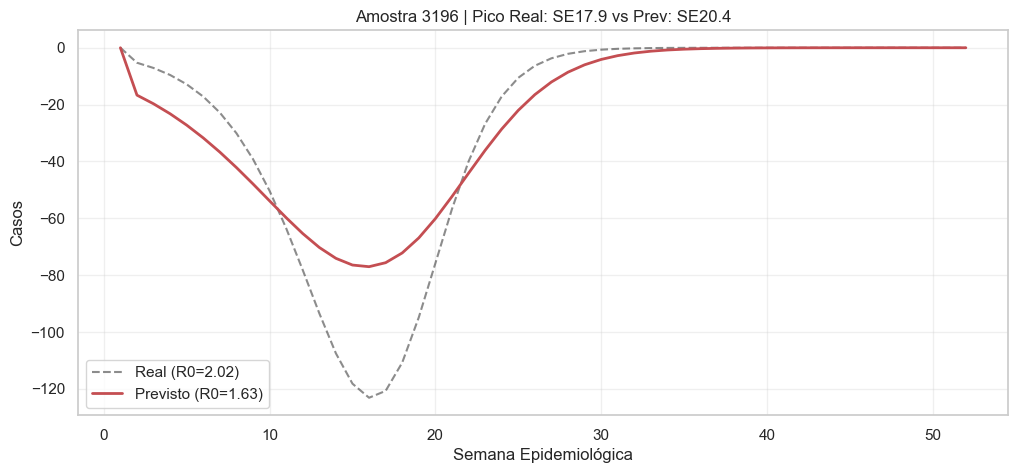

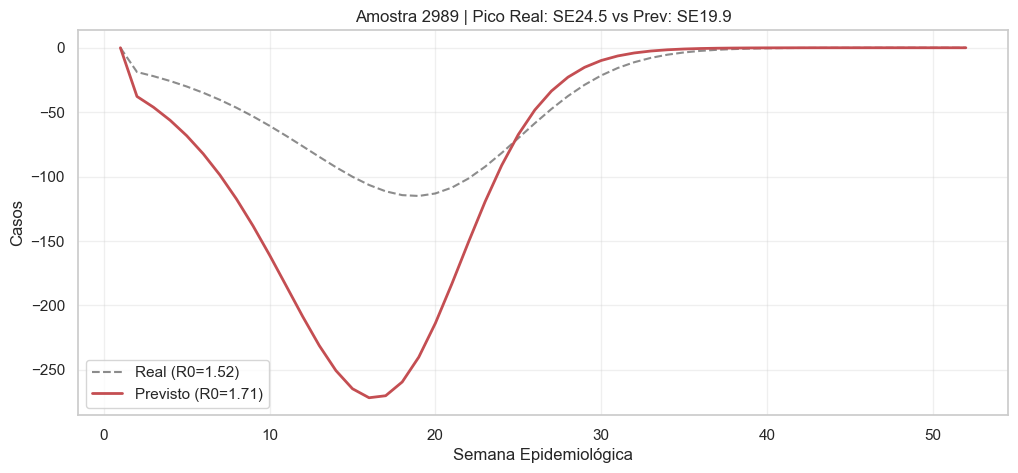

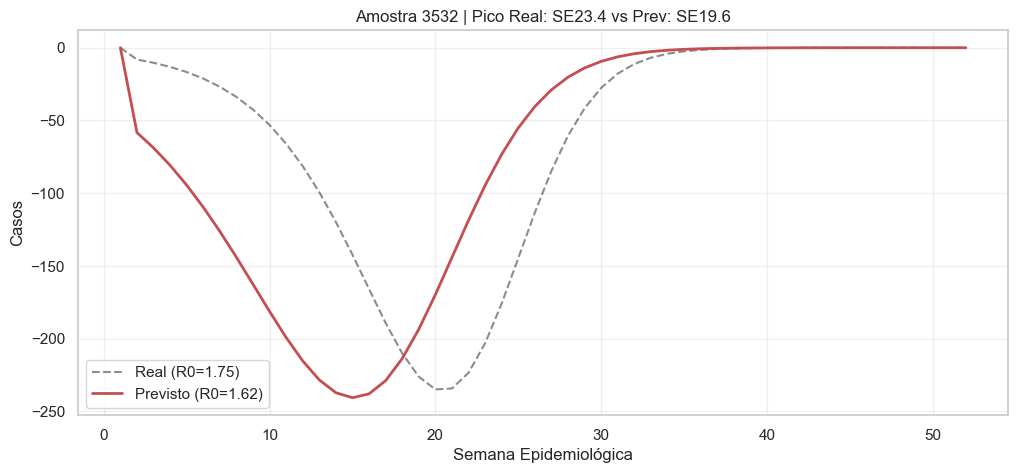

In [5]:
# 4. Plots
plot_random_examples(predictions, ground_truth, x_data)

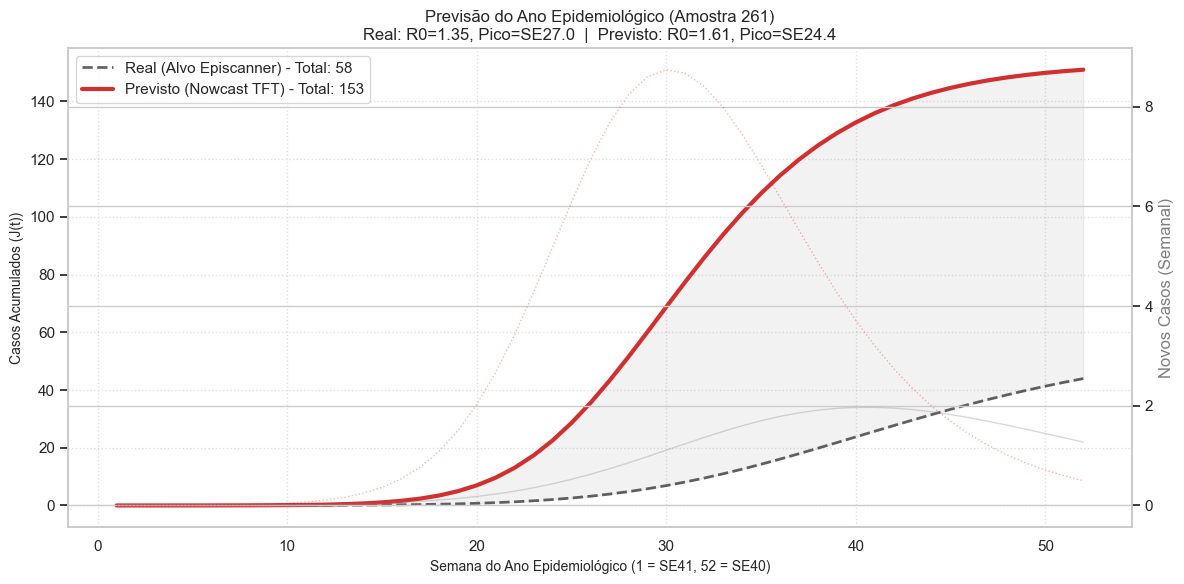

In [6]:
def richards_cumulative(t, L, t_peak, alpha, beta):
    """
    Calcula a função J(t) (Casos Acumulados) baseada na Eq. de Richards.
    """
    # ... (conversões de tensor para item continuam iguais) ...
    if isinstance(t_peak, torch.Tensor): t_peak = t_peak.item()
    if isinstance(L, torch.Tensor): L = L.item()
    if isinstance(alpha, torch.Tensor): alpha = alpha.item()
    if isinstance(beta, torch.Tensor): beta = beta.item()

    t = np.array(t)

    b = beta * alpha
    c = 1.0

    # --- CORREÇÃO AQUI: SINAL NEGATIVO ---
    # Para crescimento logístico, o expoente deve ser negativo em relação ao tempo.
    # Quando t aumenta, exp diminui, denominador vai pra 1, J(t) vai pra L.
    exponent = -b * (t - t_peak)  # <--- Adicionado o sinal de menos (-)

    exponent = np.clip(exponent, -100, 100)

    denom = 1 + c * np.exp(exponent)
    J_t = L * (denom ** (-1.0 / alpha))

    return J_t

def plot_epidemic_year_prediction(idx, preds, targets, target_names, show_incidence=False):
    """
    Plota a curva acumulada prevista vs real para um ano epidemiológico específico.

    Args:
        idx (int): Índice da amostra no dataset de validação.
        preds (list of tensors): Saída do modelo (raw_predictions.output).
        targets (list of tensors): Alvos reais (raw_predictions.y).
        target_names (list): Nomes das variáveis na ordem correta.
        show_incidence (bool): Se True, plota também a curva de novos casos (derivada).
    """
    # 1. Extrair Parâmetros (Previstos e Reais)
    params_p = {}
    params_t = {}

    # Mapear os valores baseados na ordem da lista TARGETS
    for i, name in enumerate(target_names):
        p_val = preds[i][idx].item()
        t_val = targets[0][i][idx].item() # targets[0] pois é uma lista de tuplas

        if "log_total_cases" in name:
            params_p['L'] = np.expm1(p_val) # Reverter Log
            params_t['L'] = np.expm1(t_val)
        elif "peak_week" in name:
            params_p['tp'] = p_val
            params_t['tp'] = t_val
        elif "alpha" in name:
            params_p['a'] = p_val
            params_t['a'] = t_val
        elif "beta" in name:
            params_p['b'] = p_val
            params_t['b'] = t_val
        elif "R0" in name:
            params_p['R0'] = p_val
            params_t['R0'] = t_val

    # 2. Gerar Eixo Temporal do Ano Epidemiológico (Semana 1 a 52)
    weeks = np.arange(1, 53)

    # 3. Calcular as Curvas (Acumuladas)
    curve_pred = richards_cumulative(weeks, params_p['L'], params_p['tp'], params_p['a'], params_p['b'])
    curve_true = richards_cumulative(weeks, params_t['L'], params_t['tp'], params_t['a'], params_t['b'])

    # 4. Plotagem
    fig, ax = plt.subplots(figsize=(12, 6))

    # Curvas Acumuladas
    ax.plot(weeks, curve_true, color='black', linestyle='--', linewidth=2, alpha=0.6, label=f"Real (Alvo Episcanner) - Total: {int(params_t['L'])}")
    ax.plot(weeks, curve_pred, color='#D32F2F', linewidth=3, label=f"Previsto (Nowcast TFT) - Total: {int(params_p['L'])}")

    # Área sombreada para destacar a diferença de volume
    ax.fill_between(weeks, curve_true, curve_pred, color='gray', alpha=0.1)

    # 5. Anotações e Estilo
    title = f"Previsão do Ano Epidemiológico (Amostra {idx})\n"
    subtitle = (f"Real: R0={params_t['R0']:.2f}, Pico=SE{params_t['tp']:.1f}  |  "
                f"Previsto: R0={params_p['R0']:.2f}, Pico=SE{params_p['tp']:.1f}")

    ax.set_title(title + subtitle, fontsize=12)
    ax.set_xlabel("Semana do Ano Epidemiológico (1 = SE41, 52 = SE40)", fontsize=10)
    ax.set_ylabel("Casos Acumulados (J(t))", fontsize=10)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend(loc='upper left')

    # (Opcional) Plotar Incidência (Novos Casos) em eixo secundário
    if show_incidence:
        ax2 = ax.twinx()
        inc_pred = np.diff(curve_pred, prepend=0)
        inc_true = np.diff(curve_true, prepend=0)
        ax2.plot(weeks, inc_true, color='grey', alpha=0.3, linewidth=1)
        ax2.plot(weeks, inc_pred, color='red', alpha=0.3, linewidth=1, linestyle=':')
        ax2.set_ylabel("Novos Casos (Semanal)", color='grey')

    plt.tight_layout()
    plt.show()

# --- EXEMPLO DE USO ---
# Rode isso depois de gerar as previsões com:
# raw_predictions = best_tft.predict(..., return_x=True, return_y=True)

# Escolhe um exemplo aleatório para plotar
idx_teste = random.randint(0, len(predictions[0])-1)

plot_epidemic_year_prediction(
    idx_teste,
    preds=predictions,        # Output do modelo
    targets=ground_truth,     # Alvos reais
    target_names=TARGETS,     # Lista de nomes: ["R0", "peak_week", ...]
    show_incidence=True       # True mostra também a curva de casos semanais
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🔮 Gerando previsões com índices (Inference)...

📊 MÉTRICAS POR TARGET:
  🔹 R0                        | MAE: 0.2466 | R²: 0.4717
  🔹 peak_week                 | MAE: 2.7409 | R²: 0.3850
  🔹 Total Cases (Real Scale)  | MAE: 597.1102 | R²: 0.4898
  🔹 alpha                     | MAE: 0.0628 | R²: 0.4138
  🔹 beta                      | MAE: 0.0749 | R²: 0.4776
🔄 Calculando erros para 4659 amostras de teste...

🏆 Top 10 Melhores Previsões:


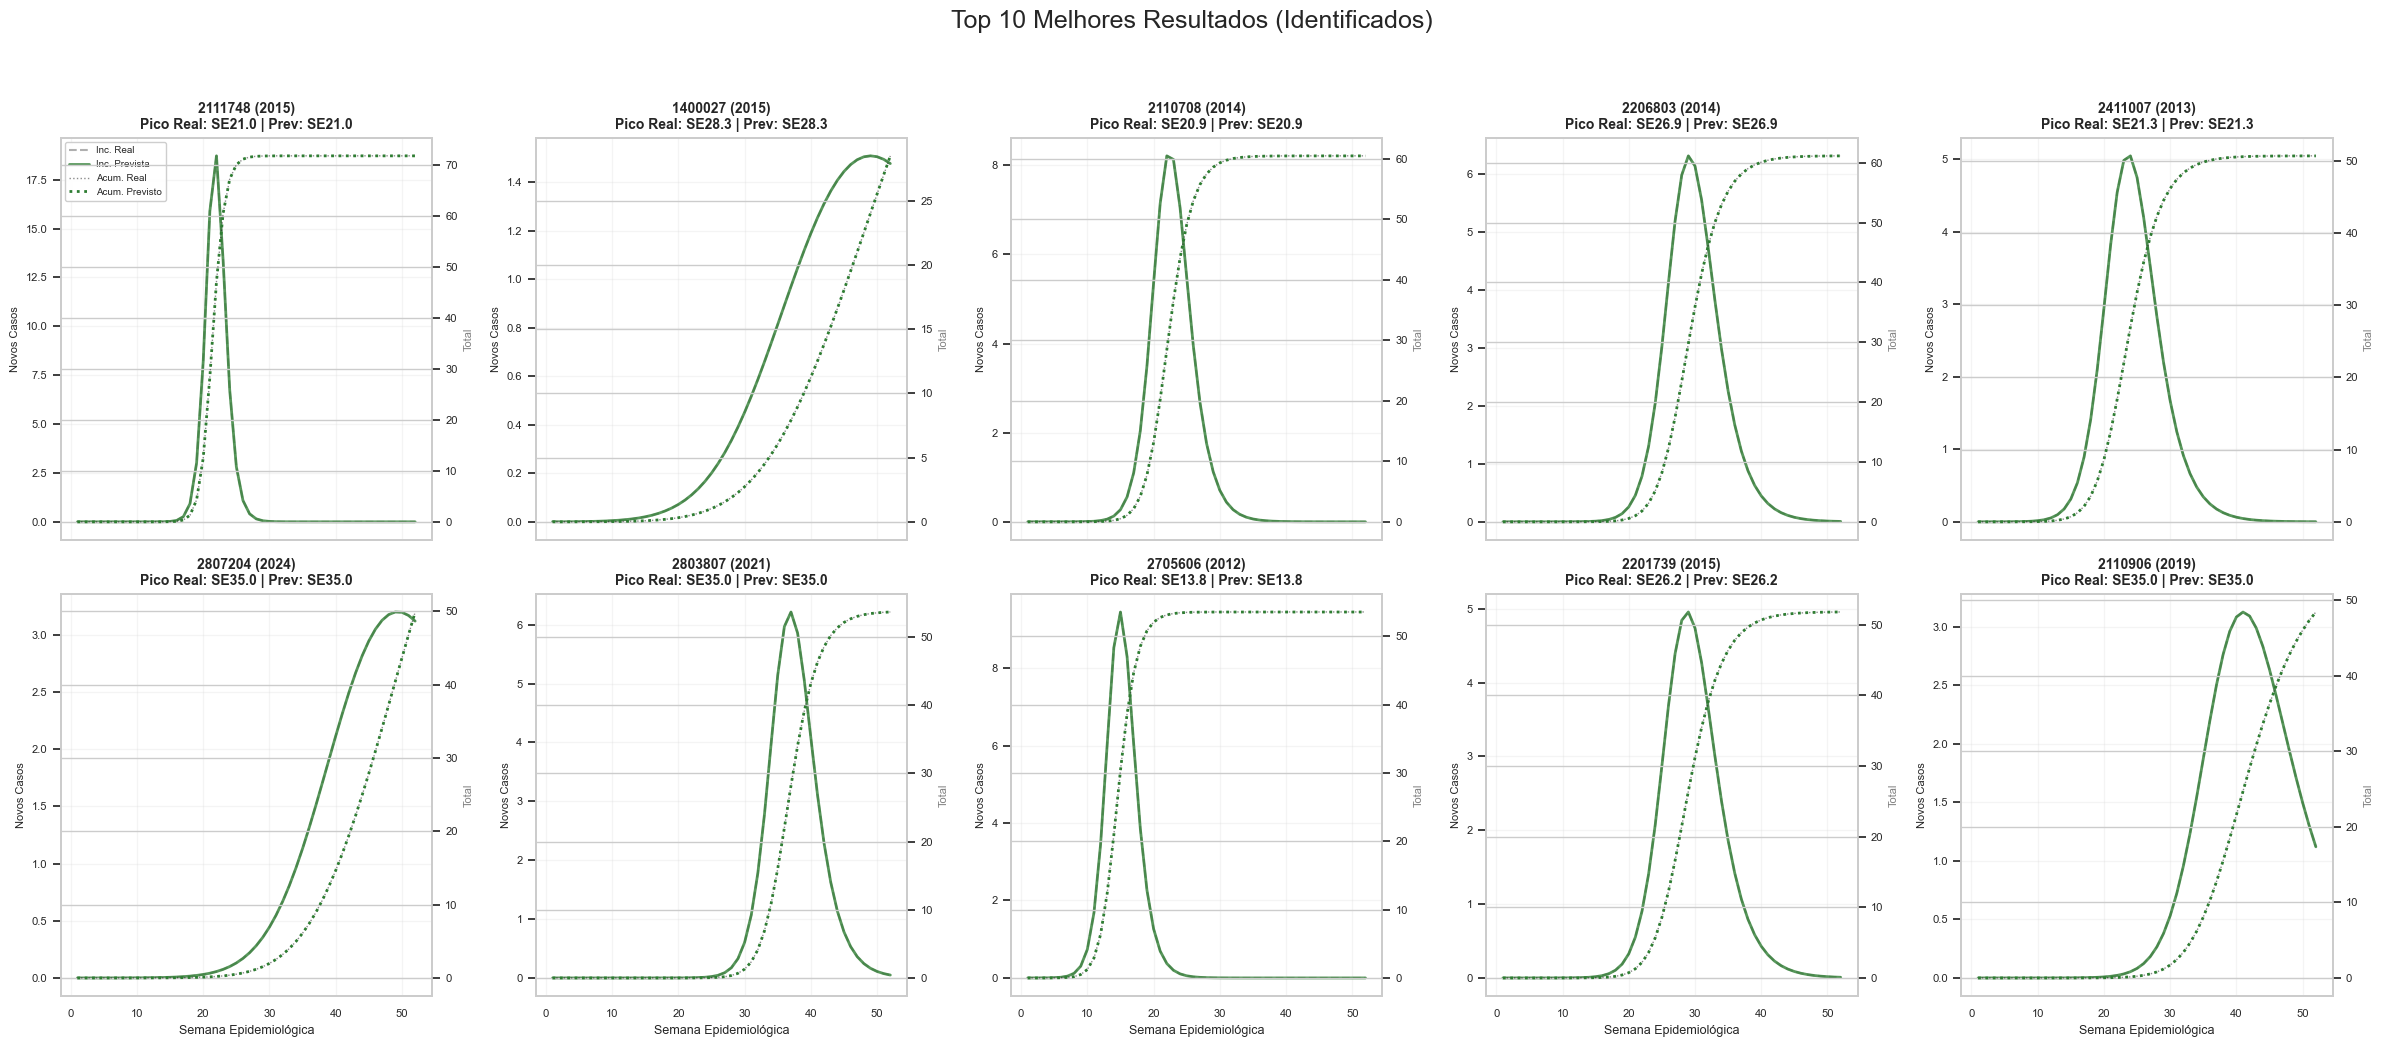


⚠️ Top 10 Piores Previsões:


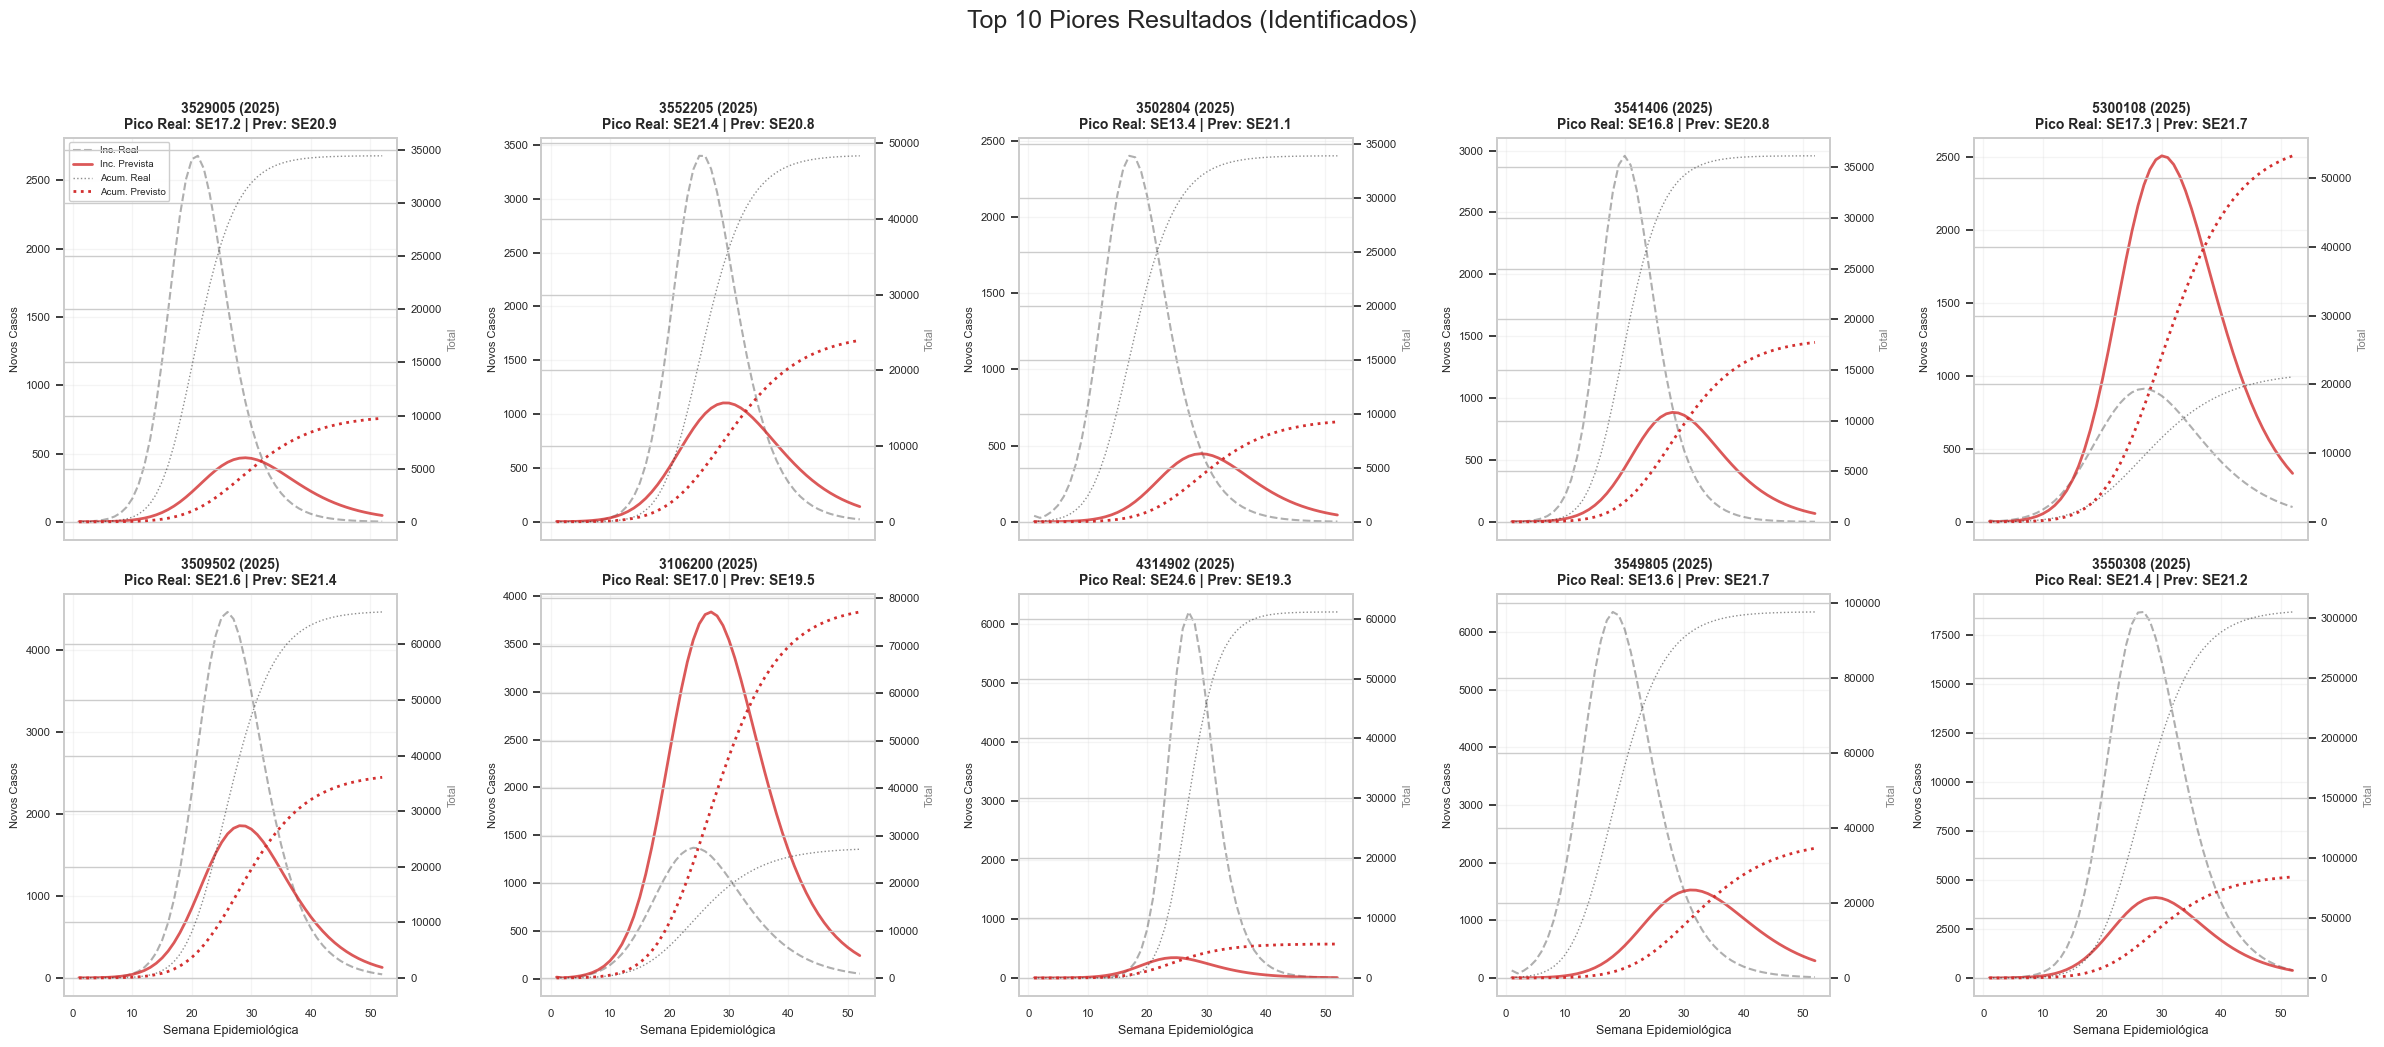

In [7]:
def evaluate_model(model, dataloader):
    print("🔮 Gerando previsões com índices (Inference)...")

    # Adicionamos return_index=True para saber QUEM é quem (geocode, time_idx)
    raw_predictions = model.predict(dataloader, mode="prediction", return_index=True, return_x=True, return_y=True)

    preds = raw_predictions.output
    targets = raw_predictions.y
    index_df = raw_predictions.index # DataFrame com colunas ['time_idx', 'geocode', ...]

    print("\n📊 MÉTRICAS POR TARGET:")
    results = []

    for i, name in enumerate(TARGETS):
        y_pred = preds[i].cpu().numpy().flatten()
        y_true = targets[0][i].cpu().numpy().flatten()

        if "log_total_cases" in name:
            y_pred = np.expm1(y_pred)
            y_true = np.expm1(y_true)
            metric_name = "Total Cases (Real Scale)"
        else:
            metric_name = name

        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        print(f"  🔹 {metric_name:<25} | MAE: {mae:.4f} | R²: {r2:.4f}")
        results.append((y_pred, y_true))

    return preds, targets, index_df
def get_richards_curves(t, L, t_peak, alpha, beta):
    """
    Retorna AMBAS as curvas: Acumulada (J) e Incidência (novos casos).
    """
    t = np.array(t)
    b = beta * alpha
    c = 1.0

    # Expoente com sinal negativo para crescimento
    exponent = -b * (t - t_peak)
    exponent = np.clip(exponent, -100, 100)

    # 1. Curva Acumulada (Sigmoide)
    denom = 1 + c * np.exp(exponent)
    J_t = L * (denom ** (-1.0 / alpha))

    # 2. Curva de Incidência (Derivada discreta)
    incidence = np.diff(J_t, prepend=0)

    return J_t, incidence
# --- 1. FUNÇÕES AUXILIARES (Reaproveitando a lógica corrigida) ---

def get_incidence_curve(t, L, t_peak, alpha, beta):
    """
    Gera a curva de novos casos (Incidência) baseada na Eq. de Richards corrigida.
    """
    # Converter tensores para float python
    if isinstance(L, torch.Tensor): L = L.item()
    if isinstance(t_peak, torch.Tensor): t_peak = t_peak.item()
    if isinstance(alpha, torch.Tensor): alpha = alpha.item()
    if isinstance(beta, torch.Tensor): beta = beta.item()

    t = np.array(t)
    b = beta * alpha
    c = 1.0

    # CORREÇÃO: Sinal negativo no expoente para crescimento logístico
    exponent = -b * (t - t_peak)
    exponent = np.clip(exponent, -100, 100)

    # Curva Acumulada J(t)
    denom = 1 + c * np.exp(exponent)
    J_t = L * (denom ** (-1.0 / alpha))

    # Incidência = J(t) - J(t-1)
    incidence = np.diff(J_t, prepend=0)
    return incidence

def calculate_all_errors(preds, targets, target_names):
    """
    Calcula o erro da curva para todas as amostras do teste.
    Retorna uma lista de tuplas: (indice, erro_medio)
    """
    errors = []
    num_samples = len(preds[0])
    weeks = np.arange(1, 53)

    print(f"🔄 Calculando erros para {num_samples} amostras de teste...")

    # --- CORREÇÃO CRÍTICA AQUI ---
    # Movemos os tensores inteiros da GPU para a CPU de uma vez só.
    # .detach() remove do grafo de gradiente (economiza RAM)
    # .cpu() move para a memória do sistema
    preds_cpu = [p.detach().cpu() for p in preds]

    # targets é uma tupla (valores, pesos), pegamos o item [0] que são os valores
    targets_cpu = [t.detach().cpu() for t in targets[0]]

    for idx in range(num_samples):
        # Extrair parâmetros
        p_vals = {}
        t_vals = {}

        for i, name in enumerate(target_names):
            # Usamos .item() para pegar o valor escalar puro do Python
            p = preds_cpu[i][idx].item()
            t = targets_cpu[i][idx].item()

            if "log_total_cases" in name:
                p_vals['L'] = np.expm1(p)
                t_vals['L'] = np.expm1(t)
            elif "peak_week" in name:
                p_vals['tp'] = p
                t_vals['tp'] = t
            elif "alpha" in name:
                p_vals['a'] = p
                t_vals['a'] = t
            elif "beta" in name:
                p_vals['b'] = p
                t_vals['b'] = t

        # Gerar Curvas
        curve_pred = get_incidence_curve(weeks, p_vals['L'], p_vals['tp'], p_vals['a'], p_vals['b'])
        curve_true = get_incidence_curve(weeks, t_vals['L'], t_vals['tp'], t_vals['a'], t_vals['b'])

        # Calcular MAE da curva (diferença média de casos por semana)
        mae = np.mean(np.abs(curve_pred - curve_true))
        errors.append((idx, mae))

    return errors


def plot_grid_results(indices, preds, targets, target_names, title, color_pred='red'):
    """
    Plota um grid 2x5 mostrando Incidência (Eixo Esq) e Acumulado (Eixo Dir).
    """
    fig, axes = plt.subplots(2, 5, figsize=(24, 10)) # Aumentei a largura
    fig.suptitle(title, fontsize=18, y=0.98)
    axes = axes.flatten()

    weeks = np.arange(1, 53)

    for i, idx in enumerate(indices):
        ax1 = axes[i]

        # Extrair Parâmetros (Usando .item() para compatibilidade GPU/CPU)
        p_vals, t_vals = {}, {}
        for k, name in enumerate(target_names):
            # Extrai valor escalar seguro
            p = preds[k][idx].item() if isinstance(preds[k][idx], torch.Tensor) else preds[k][idx]
            t = targets[0][k][idx].item() if isinstance(targets[0][k][idx], torch.Tensor) else targets[0][k][idx]

            if "log_total_cases" in name:
                p_vals['L'] = np.expm1(p)
                t_vals['L'] = np.expm1(t)
            elif "peak_week" in name:
                p_vals['tp'] = p
                t_vals['tp'] = t
            elif "alpha" in name:
                p_vals['a'] = p
                t_vals['a'] = t
            elif "beta" in name:
                p_vals['b'] = p
                t_vals['b'] = t

        # Gerar Dados das Curvas
        acc_pred, inc_pred = get_richards_curves(weeks, p_vals['L'], p_vals['tp'], p_vals['a'], p_vals['b'])
        acc_true, inc_true = get_richards_curves(weeks, t_vals['L'], t_vals['tp'], t_vals['a'], t_vals['b'])

        # --- PLOT 1: INCIDÊNCIA (Eixo Esquerdo) ---
        # Real = Linha preta tracejada
        # Previsto = Linha colorida sólida
        l1, = ax1.plot(weeks, inc_true, 'k--', alpha=0.4, label='Incidência Real')
        l2, = ax1.plot(weeks, inc_pred, color=color_pred, linewidth=2, alpha=0.8, label='Incidência Prevista')

        ax1.set_ylabel("Novos Casos", fontsize=9)
        ax1.tick_params(axis='y', labelsize=8)

        # --- PLOT 2: ACUMULADO (Eixo Direito) ---
        ax2 = ax1.twinx()
        # Real = Pontilhado cinza
        # Previsto = Pontilhado colorido
        l3, = ax2.plot(weeks, acc_true, 'k:', linewidth=1.5, alpha=0.5, label='Acumulado Real')
        l4, = ax2.plot(weeks, acc_pred, color=color_pred, linestyle=':', linewidth=2, label='Acumulado Previsto')

        ax2.set_ylabel("Total Acumulado", fontsize=9, color='gray')
        ax2.tick_params(axis='y', labelcolor='gray', labelsize=8)

        # Título com Erro do Pico
        peak_error = abs(p_vals['tp'] - t_vals['tp'])
        total_error_pct = abs(p_vals['L'] - t_vals['L']) / (t_vals['L'] + 1) * 100

        ax1.set_title(f"Amostra {idx}\nErro Pico: {peak_error:.1f} sem | Erro Total: {total_error_pct:.0f}%", fontsize=10, fontweight='bold')
        ax1.grid(True, alpha=0.2)

        # Legenda unificada apenas no primeiro gráfico
        if i == 0:
            lines = [l1, l2, l3, l4]
            labels = [l.get_label() for l in lines]
            ax1.legend(lines, labels, loc='upper left', fontsize=8, framealpha=0.9)

        # Remover ticks X para limpar, exceto na última linha
        if i < 5: ax1.set_xticklabels([])
        else: ax1.set_xlabel("Semana Epidemiológica")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_grid_results(indices, preds, targets, target_names, index_df, original_data, title, color_pred='red', save_path = "../reports/images/"):
    """
    Plota grid com identificação da Cidade e Ano.
    """
    fig, axes = plt.subplots(2, 5, figsize=(24, 11))
    fig.suptitle(title, fontsize=18, y=0.98)
    axes = axes.flatten()

    weeks = np.arange(1, 53)

    # Criar lookup para nomes de cidades se disponível
    # Tenta achar colunas de nome comuns
    name_col = next((c for c in ['geocode_name', 'muni_name', 'city', 'NM_MUNICIP'] if c in original_data.columns), None)

    for i, idx in enumerate(indices):
        ax1 = axes[i]

        # 1. Recuperar Metadados (Cidade e Ano)
        # Pegamos o geocode e time_idx dessa previsão específica
        row_idx = index_df.iloc[idx]
        geo_code = row_idx['geocode']
        t_idx = row_idx['time_idx']

        # Buscamos no dataframe original para pegar o Ano e Nome
        # Filtramos pelo geocode e time_idx (ou próximo se houver gap, mas no teste é exato)
        meta_row = original_data[(original_data['geocode'] == geo_code) & (original_data['time_idx'] == t_idx)]

        if not meta_row.empty:
            year_val = meta_row['year'].values[0]
            city_name = meta_row[name_col].values[0] if name_col else geo_code
        else:
            year_val = "Desc."
            city_name = geo_code

        # 2. Extrair Parâmetros
        p_vals, t_vals = {}, {}
        for k, name in enumerate(target_names):
            p = preds[k][idx].item() if isinstance(preds[k][idx], torch.Tensor) else preds[k][idx]
            t = targets[0][k][idx].item() if isinstance(targets[0][k][idx], torch.Tensor) else targets[0][k][idx]

            if "log_total_cases" in name:
                p_vals['L'] = np.expm1(p)
                t_vals['L'] = np.expm1(t)
            elif "peak_week" in name:
                p_vals['tp'] = p
                t_vals['tp'] = t
            elif "alpha" in name:
                p_vals['a'] = p
                t_vals['a'] = t
            elif "beta" in name:
                p_vals['b'] = p
                t_vals['b'] = t

        # 3. Gerar Curvas
        acc_pred, inc_pred = get_richards_curves(weeks, p_vals['L'], p_vals['tp'], p_vals['a'], p_vals['b'])
        acc_true, inc_true = get_richards_curves(weeks, t_vals['L'], t_vals['tp'], t_vals['a'], t_vals['b'])

        # 4. Plot
        l1, = ax1.plot(weeks, inc_true, 'k--', alpha=0.35, label='Incidência Real')
        l2, = ax1.plot(weeks, inc_pred, color=color_pred, linewidth=2, alpha=0.8, label='Incidência Prevista')

        ax2 = ax1.twinx()
        l3, = ax2.plot(weeks, acc_true, 'k:', linewidth=1, alpha=0.5, label='Acumulado Real')
        l4, = ax2.plot(weeks, acc_pred, color=color_pred, linestyle=':', linewidth=2, label='Acumulado Previsto')

        # Título Rico com Metadados
        # Quebra o nome da cidade se for muito longo
        city_display = (city_name[:20] + '..') if len(str(city_name)) > 20 else city_name

        header = f"{city_display} ({year_val})\n"
        stats = f"Pico Real: SE{t_vals['tp']:.1f} | Prev: SE{p_vals['tp']:.1f}"

        ax1.set_title(header + stats, fontsize=10, fontweight='bold')

        # Eixos e Grid
        ax1.set_ylabel("Novos Casos", fontsize=8)
        ax2.set_ylabel("Total", fontsize=8, color='gray')
        ax1.grid(True, alpha=0.2)
        ax1.tick_params(labelsize=8)
        ax2.tick_params(labelsize=8)

        # Legenda Limpa (Apenas no primeiro plot)
        if i == 0:
            lines = [l1, l2, l3, l4]
            labels = ["Inc. Real", "Inc. Prevista", "Acum. Real", "Acum. Previsto"]
            ax1.legend(lines, labels, loc='upper left', fontsize=7, framealpha=0.95)

        if i < 5: ax1.set_xticklabels([])
        else: ax1.set_xlabel("Semana Epidemiológica", fontsize=9)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path + title + ".png", dpi=300)
    plt.show()



# --- 2. EXECUÇÃO ---

# 1. Calcular erros de todas as amostras
# (Assumindo que 'predictions' e 'ground_truth' já existem do passo anterior)
predictions, ground_truth, prediction_index = evaluate_model(best_tft, val_dataloader)

# 2. Recalcular erros (Se necessário)
if 'all_errors' not in locals():
    all_errors = calculate_all_errors(predictions, ground_truth, TARGETS)
    sorted_errors = sorted(all_errors, key=lambda x: x[1])
    best_10_indices = [x[0] for x in sorted_errors[:10]]
    worst_10_indices = [x[0] for x in sorted_errors[-10:]]

# 3. Plotar Melhores com Nomes
print(f"\n🏆 Top 10 Melhores Previsões:")
plot_grid_results(
    best_10_indices,
    predictions,
    ground_truth,
    TARGETS,
    prediction_index, # <--- Passamos o índice aqui
    data,             # <--- Passamos o dataframe original para lookup
    title="Top 10 Melhores Resultados (Identificados)",
    color_pred='#2E7D32'
)

# 4. Plotar Piores com Nomes
print(f"\n⚠️ Top 10 Piores Previsões:")
plot_grid_results(
    worst_10_indices,
    predictions,
    ground_truth,
    TARGETS,
    prediction_index,
    data,
    title="Top 10 Piores Resultados (Identificados)",
    color_pred='#D32F2F'
)

In [8]:
def visualize_unseen_validation(model, val_dataloader, original_data, n=5):
    """
    Plota previsões aleatórias extraídas EXCLUSIVAMENTE do Dataloader de Validação.
    """
    print(f"🔮 Gerando previsões no conjunto de VALIDAÇÃO (n={n})...")

    # 1. Gerar Previsões (Inference)
    # Retorna: output (previsões), x (inputs), index (ids das linhas)
    raw_predictions = model.predict(val_dataloader, mode="prediction", return_index=True, return_x=True, return_y=True)

    preds = raw_predictions.output
    targets = raw_predictions.y
    index_df = raw_predictions.index

    # 2. Selecionar índices aleatórios
    total_samples = len(index_df)
    if total_samples == 0:
        print("⚠️ O dataset de validação está vazio. Verifique o corte de tempo.")
        return

    random_indices = random.sample(range(total_samples), min(n, total_samples))

    # 3. Plotar usando a função de grid que já criamos (reutilizando lógica)
    # (Certifique-se de que a função plot_grid_results do passo anterior está carregada)
    plot_grid_results(
        indices=random_indices,
        preds=preds,
        targets=targets,
        target_names=TARGETS, # Variável global definida anteriormente
        index_df=index_df,
        original_data=original_data,
        title=f"Previsões em Dados Não Vistos (Validação) - {n} Exemplos Aleatórios",
        color_pred='#9C27B0' # Roxo para diferenciar
    )

# --- FUNÇÃO 2: PREVER O PRÓXIMO ANO (FORECAST PURO) ---

def forecast_next_season(model, data, known_reals, unknown_reals, statics, targets):
    """
    Versão Corrigida: Usa model.dataset_parameters para reconstruir os encoders.
    """
    print("🚀 Preparando dados para prever a PRÓXIMA TEMPORADA (Versão Final)...")

    # 1. Descobrir qual é o "Presente" real
    max_time_idx = data['time_idx'].max()
    current_year = data[data['time_idx'] == max_time_idx]['year'].mode()[0]
    print(f"📅 Ano de referência mais recente nos dados: {current_year}")

    # 2. FILTRAGEM DE CIDADES ATIVAS
    recent_threshold = max_time_idx - 4
    active_cities = data[data['time_idx'] >= recent_threshold]['geocode'].unique()

    print(f"   - Total de cidades no banco: {data['geocode'].nunique()}")
    print(f"   - Cidades ativas recentemente (serão previstas): {len(active_cities)}")

    history_window = 60
    data_active = data[
        (data['geocode'].isin(active_cities)) &
        (data['time_idx'] > max_time_idx - history_window)
    ].copy()

    # 3. CRIAR O FUTURO (Decoder)
    last_entries = data_active.sort_values("time_idx").groupby("geocode").tail(1).copy()

    future_df = last_entries.copy()

    # Avançar Tempo
    future_df["time_idx"] += 1

    # Lógica de Virada de Ano
    future_df.loc[future_df['month'] == 12, 'year'] += 1
    future_df.loc[future_df['month'] == 12, 'month'] = 1
    future_df.loc[future_df['month'] != 1, 'month'] += 1

    # Zerar Variáveis Desconhecidas
    for col in ["casos", "incidence", "tda_entropy_H1", "tda_amplitude_H1"]:
        if col in future_df.columns:
            future_df[col] = 0.0

    # 4. JUNTAR HISTÓRICO + FUTURO
    inference_data = pd.concat([data_active, future_df], ignore_index=True)
    inference_data = inference_data.sort_values(['geocode', 'time_idx']).reset_index(drop=True)

    print(f"🔮 Gerando Dataloader para {len(active_cities)} cidades...")

    # --- CORREÇÃO AQUI ---
    # Em vez de from_dataset(model.dataset...), usamos from_parameters
    # Isso garante que usamos os MESMOS encoders do treino
    inference_dataset = TimeSeriesDataSet.from_parameters(
        model.dataset_parameters,
        inference_data,
        predict=True,
        stop_randomization=True
    )

    inf_dataloader = inference_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

    # 5. PREVER
    # return_index=True é vital para saber qual previsão pertence a qual cidade
    raw_predictions = model.predict(inf_dataloader, mode="prediction", return_index=True)
    preds = raw_predictions.output
    index = raw_predictions.index

    # 6. FORMATAR SAÍDA
    results = pd.DataFrame()
    results['geocode'] = index['geocode']

    # Tenta pegar o ano do futuro que criamos
    # Fazemos um merge rápido para pegar o ano correspondente ao time_idx previsto
    # O time_idx da previsão é o último do input (decoder)
    future_years = future_df[['geocode', 'time_idx', 'year']].rename(columns={'year': 'Forecast_Year'})
    results = results.merge(future_years, on=['geocode'], how='left') # Merge simplificado pelo geocode pois só tem 1 futuro por cidade

    # Extrair valores
    # preds é uma lista de tensores [R0, Peak, Total, Alpha, Beta]
    results['Pred_R0'] = preds[0].cpu().numpy().flatten()
    results['Pred_Peak_Week'] = preds[1].cpu().numpy().flatten()
    results['Pred_Total_Cases'] = np.expm1(preds[2].cpu().numpy().flatten())

    if len(preds) > 3:
        results['Pred_Alpha'] = preds[3].cpu().numpy().flatten()
        results['Pred_Beta'] = preds[4].cpu().numpy().flatten()

    print("✅ Previsão Concluída!")
    return results

def plot_future_forecast(results_df, n=3):
    """
    Desenha a curva prevista para o futuro (sem dados reais para comparar, pois é o futuro!).
    """
    sample = results_df.sample(n)
    weeks = np.arange(1, 53)

    plt.figure(figsize=(15, 5), facecolor='white')

    for i, (idx, row) in enumerate(sample.iterrows()):
        L = row['Pred_Total_Cases']
        tp = row['Pred_Peak_Week']
        a = row['Pred_Alpha']
        b = row['Pred_Beta']

        # Calcular Curva de Incidência (Novos Casos)
        # Usando a função richards_curve_diff definida anteriormente
        # Lembre-se: richards_cumulative é a acumulada, aqui queremos a diária/semanal

        # Recriando logica rapida de incidencia se nao tiver a funcao importada
        # (Idealmente use a função que já definimos no bloco anterior)
        # Mas vou usar a get_richards_curves para garantir
        _, inc = get_richards_curves(weeks, L, tp, a, b)

        city = row['geocode_name'] if 'geocode_name' in row else row['geocode']

        plt.subplot(1, 3, i+1)
        plt.plot(weeks, inc, color='#FF5722', linewidth=2.5, label='Previsão 2025/26')
        plt.title(f"{city}\nR0: {row['Pred_R0']:.2f} | Pico: SE{tp:.1f}")
        plt.xlabel("Semana Epidemiológica Futura")
        plt.ylabel("Casos Previstos")
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🔮 Gerando previsões no conjunto de VALIDAÇÃO (n=10)...


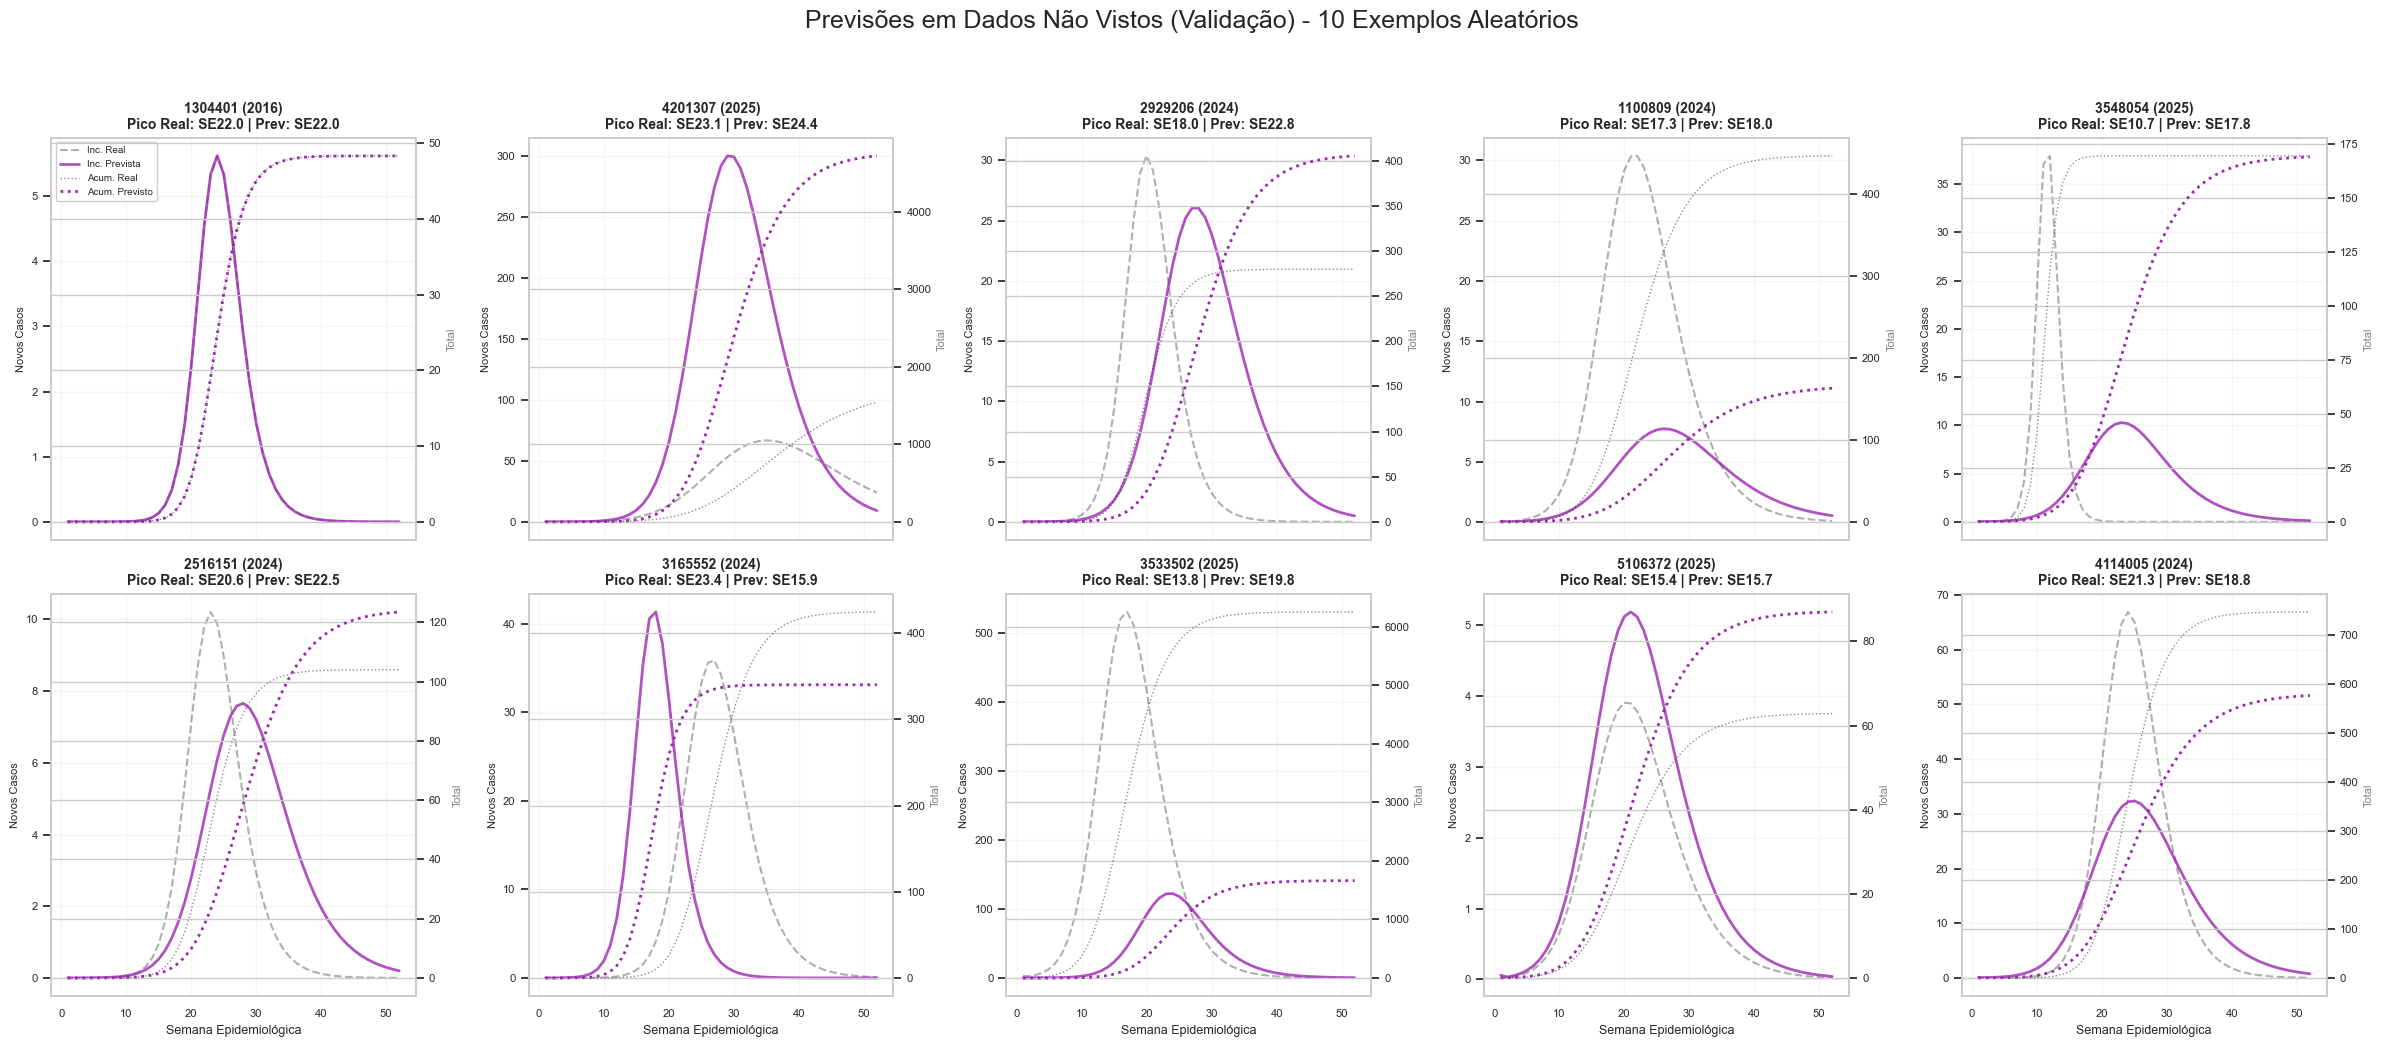

In [9]:
# Chama a função que criamos agora
visualize_unseen_validation(best_tft, val_dataloader, data, n=10)

In [10]:
# 1. Carregar dados COMPLETOS (sem filtrar pelos Targets que queremos prever)
print("📂 Carregando dataset completo para inferência...")
data_full = pd.read_parquet(DATA_PATH)

# Garantir tipos
data_full["time_idx"] = data_full["time_idx"].astype(int)
data_full["geocode"] = data_full["geocode"].astype(str)
for col in STATIC_CATEGORICALS:
    if col in data_full.columns:
        data_full[col] = data_full[col].astype(str)

# 2. Filtrar apenas colunas de INPUT (ignorando se R0/Pico são nulos)
# Precisamos garantir que temos Casos, Clima e População não nulos
input_cols = TIME_VARYING_KNOWN_REALS + TIME_VARYING_UNKNOWN_REALS + STATIC_REALS
input_cols = [c for c in input_cols if c in data_full.columns]

# Limpeza leve (apenas se faltar input essencial)
data_inference = data_full.dropna(subset=input_cols).copy()

print(f"📅 Último ano disponível nos dados: {data_inference['year'].max()}")
# Agora deve mostrar 2024 ou 2025

# 3. Rodar a previsão usando esse dataframe completo
future_results = forecast_next_season(
    best_tft,
    data_inference, # <--- Use este dataframe novo
    TIME_VARYING_KNOWN_REALS,
    TIME_VARYING_UNKNOWN_REALS,
    STATIC_CATEGORICALS,
    TARGETS
)

display(future_results.head())

📂 Carregando dataset completo para inferência...
📅 Último ano disponível nos dados: 2025
🚀 Preparando dados para prever a PRÓXIMA TEMPORADA (Versão Final)...
📅 Ano de referência mais recente nos dados: 2025
   - Total de cidades no banco: 4659
   - Cidades ativas recentemente (serão previstas): 2217
🔮 Gerando Dataloader para 2217 cidades...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


✅ Previsão Concluída!


geocode  time_idx  Forecast_Year   Pred_R0  Pred_Peak_Week  \
0  1100015       804           2025  1.536521       16.538742   
1  1100023       804           2025  1.460823       16.558205   
2  1100031       804           2025  1.782656       16.720175   
3  1100056       804           2025  1.851339       15.564276   
4  1100072       804           2025  2.004720       17.080132   

   Pred_Total_Cases  Pred_Alpha  Pred_Beta  
0        449.243011    0.354888   0.466274  
1        630.126892    0.320512   0.448577  
2        100.415550    0.443304   0.544895  
3        393.278290    0.460322   0.550284  
4         85.947655    0.515960   0.600621

In [11]:
# see max forecast_year of future_results
print(f"Max Forecast Year: {future_results['Forecast_Year'].max()}")


Max Forecast Year: 2025


In [12]:
data_full

date  epiweek  geocode  casos  uf  macroregional_geocode  \
0        2011-01-02   201101  1100015      0  RO                   1101   
1        2011-01-09   201102  1100015      0  RO                   1101   
2        2011-01-16   201103  1100015      2  RO                   1101   
3        2011-01-23   201104  1100015      0  RO                   1101   
4        2011-01-30   201105  1100015      0  RO                   1101   
...             ...      ...      ...    ...  ..                    ...   
1322418  2025-04-27   202518  5300108    354  DF                   5302   
1322419  2025-05-04   202519  5300108    418  DF                   5302   
1322420  2025-05-11   202520  5300108    301  DF                   5302   
1322421  2025-05-18   202521  5300108    352  DF                   5302   
1322422  2025-05-25   202522  5300108    166  DF                   5302   

         regional_geocode  train_1  target_1  train_2  target_2  train_3  \
0                   11005     True     False     True     False     True   
1                   11005     True     False     True     False     True   
2                   11005     True     False     True     False     True   
3                   11005     True     False     True     False     True   
4                   11005     True     False     True     False     True   
...                   ...      ...       ...      ...       ...      ...   
1322418             53001    False     False    False     False    False   
1322419             53001    False     False    False     False    False   
1322420             53001    False     False    False     False    False   
1322421             53001    False     False    False     False    False   
1322422             53001    False     False    False     False    False   

         target_3  year  month  time_idx  week_of_year  week_cycle  \
0           False  2011      1        52             1          13   
1           False  2011      1        53             2          14   
2           False  2011      1        54             3          15   
3           False  2011      1        55             4          16   
4           False  2011      1        56             5          17   
...           ...   ...    ...       ...           ...         ...   
1322418      True  2025      4       799            18          30   
1322419      True  2025      5       800            19          31   
1322420      True  2025      5       801            20          32   
1322421      True  2025      5       802            21          33   
1322422      True  2025      5       803            22          34   

         sin_week_cycle  cos_week_cycle   temp_min   temp_med   temp_max  \
0              1.000000   -1.608123e-16  22.194815  24.659414  28.058685   
1              0.992709   -1.205367e-01  23.102514  25.861757  29.373228   
2              0.970942   -2.393157e-01  22.708115  24.887714  28.102085   
3              0.935016   -3.546049e-01  22.099928  24.397657  28.119286   
4              0.885456   -4.647232e-01  22.840042  25.728371  29.895243   
...                 ...             ...        ...        ...        ...   
1322418       -0.464723   -8.854560e-01  18.991833  22.945667  27.115700   
1322419       -0.568065   -8.229839e-01  18.991833  22.945667  27.115700   
1322420       -0.663123   -7.485108e-01  18.991833  22.945667  27.115700   
1322421       -0.748511   -6.631227e-01  18.991833  22.945667  27.115700   
1322422       -0.822984   -5.680647e-01  18.991833  22.945667  27.115700   

         precip_min  precip_med  precip_max  pressure_min  pressure_med  \
0            3.9964   32.489300   93.736198      0.964657      0.967329   
1            0.8215   15.186200   46.449902      0.964986      0.967971   
2            1.8265   28.807301   84.472000      0.964643      0.967186   
3            5.6922   26.469900   80.710899      0.966786      0.969343   
4            1.1087   16.936800   52.370998      0.966500      0.970043 

In [13]:


# ==========================================
# 1. CONFIGURAÇÕES
# ==========================================
# Ajuste os caminhos conforme seu ambiente
DATA_PATH = ("../data/processed/dataset_inference.parquet")  # O arquivo que geramos no passo anterior

# Variáveis (Devem ser idênticas ao treino)
TARGETS = ["R0", "peak_week", "log_total_cases", "alpha", "beta"]
STATIC_CATEGORICALS = ["uf", "koppen", "biome", "macroregion_name"]
STATIC_REALS = ["num_neighbors"]
TIME_VARYING_KNOWN_REALS = [
    "time_idx", "week_cycle", "sin_week_cycle", "cos_week_cycle", "log_pop",
    "forecast_temp_med", "forecast_precip_tot"
]
TIME_VARYING_UNKNOWN_REALS = [
    "casos", "incidence", "temp_med", "precip_med", "rel_humid_med",
    "enso", "iod", "tda_entropy_H1", "tda_amplitude_H1"
]

# ==========================================
# 2. FUNÇÃO DE PREVISÃO (2025/2026)
# ==========================================
def predict_season_2026(model, data):
    print("🚀 Iniciando Previsão para a Temporada 2025/2026...")

    # 1. Identificar o "Presente" (Último ponto de dados reais)
    max_time_idx = data['time_idx'].max()
    current_year = data['year'].max()
    print(f"📅 Último registro nos dados: Ano {current_year} (Index {max_time_idx})")

    # 2. Filtrar cidades ativas
    # (Pega apenas cidades que têm dados recentes, para evitar prever para cidades 'mortas' de 2010)
    active_threshold = max_time_idx - 10
    active_cities = data[data['time_idx'] >= active_threshold]['geocode'].unique()
    print(f"🏙️ Cidades ativas para previsão: {len(active_cities)}")

    # Pegamos o histórico recente (Encoder) dessas cidades
    # O TFT precisa de pelo menos 'min_encoder_length' (20) semanas de histórico
    history_window = 60
    data_history = data[
        (data['geocode'].isin(active_cities)) &
        (data['time_idx'] > max_time_idx - history_window)
    ].copy()

    # 3. Criar o "Futuro" (Decoder)
    # Para prever a temporada 2026, precisamos criar uma linha de tempo nova
    # Vamos pegar a última linha de cada cidade e avançar 1 passo no tempo
    # Isso simula o "início" da nova temporada

    last_rows = data_history.sort_values("time_idx").groupby("geocode").tail(1).copy()
    future_df = last_rows.copy()

    # A. Atualizar Tempo
    future_df["time_idx"] += 1
    future_df["year"] = current_year + 1 # Joga para 2025/26

    # B. Zerar Variáveis Desconhecidas (Cold Start)
    # Como é o futuro, não sabemos os casos nem a topologia ainda.
    # O modelo vai ter que chutar baseado no clima/estáticos.
    for col in TIME_VARYING_UNKNOWN_REALS:
        if col in future_df.columns:
            future_df[col] = 0.0

    # C. Atualizar Variáveis Conhecidas (Sazonalidade)
    # Avança o ciclo semanal (simulação simples)
    # Se quiser ser preciso, teria que recalcular sin/cos da semana real
    # Aqui mantemos a continuidade do ciclo anterior
    future_df["week_cycle"] = future_df["week_cycle"].apply(lambda x: x + 1 if x < 52 else 1)
    future_df["sin_week_cycle"] = np.sin(2 * np.pi * future_df["week_cycle"] / 52)
    future_df["cos_week_cycle"] = np.cos(2 * np.pi * future_df["week_cycle"] / 52)

    # 4. Juntar Histórico + Futuro
    inference_data = pd.concat([data_history, future_df], ignore_index=True)
    inference_data = inference_data.sort_values(['geocode', 'time_idx']).reset_index(drop=True)

    # 5. Criar Dataloader
    print("🔮 Gerando Dataloader de Inferência...")

    # --- CORREÇÃO DO ATRIBUTO DATASET ---
    # Usamos from_dataset passando model.dataset_parameters (config interna salva)
    # ou recriamos manualmente se parameters falhar (fallback seguro)
    try:
        inference_dataset = TimeSeriesDataSet.from_parameters(
            model.dataset_parameters,
            inference_data,
            predict=True,
            stop_randomization=True
        )
    except AttributeError:
        # Fallback: Se o modelo não tiver parameters expostos, recriamos com as configs globais
        print("⚠️ Aviso: Usando recriação manual do dataset (Fallback)...")
        # Precisamos de um normalizador dummy (igual ao treino)
        from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer
        target_normalizer = MultiNormalizer([
            GroupNormalizer(groups=["geocode"], transformation="softplus"), # R0
            GroupNormalizer(groups=["geocode"], transformation="softplus"), # Peak
            GroupNormalizer(groups=["geocode"], transformation=None),       # Total
            GroupNormalizer(groups=["geocode"], transformation="logit"),    # Alpha
            GroupNormalizer(groups=["geocode"], transformation="softplus")  # Beta
        ])

        inference_dataset = TimeSeriesDataSet(
            inference_data,
            time_idx="time_idx",
            target=TARGETS,
            group_ids=["geocode"],
            min_encoder_length=20, max_encoder_length=52,
            min_prediction_length=1, max_prediction_length=1,
            static_categoricals=STATIC_CATEGORICALS,
            static_reals=STATIC_REALS,
            time_varying_known_reals=TIME_VARYING_KNOWN_REALS,
            time_varying_unknown_reals=TIME_VARYING_UNKNOWN_REALS,
            target_normalizer=target_normalizer,
            allow_missing_timesteps=True,
            predict_mode=True
        )

    inf_dataloader = inference_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

    # 6. Previsão
    print("🧠 Executando a Rede Neural...")
    raw_predictions = model.predict(inf_dataloader, mode="prediction", return_index=True)
    preds = raw_predictions.output
    index = raw_predictions.index

    # 7. Organizar Resultados
    results = pd.DataFrame()
    results['geocode'] = index['geocode']
    results['Forecast_Year'] = future_df['year'].iloc[0] # Ano previsto

    # Extrair valores dos tensores
    results['Pred_R0'] = preds[0].cpu().numpy().flatten()
    results['Pred_Peak_Week'] = preds[1].cpu().numpy().flatten()
    results['Pred_Total_Cases_Log'] = preds[2].cpu().numpy().flatten()
    results['Pred_Total_Cases'] = np.expm1(results['Pred_Total_Cases_Log']).astype(int)

    if len(preds) > 3:
        results['Pred_Alpha'] = preds[3].cpu().numpy().flatten()
        results['Pred_Beta'] = preds[4].cpu().numpy().flatten()

    # Adicionar nomes se disponíveis
    if 'geocode_name' in data.columns:
        names = data[['geocode', 'geocode_name', 'uf']].drop_duplicates()
        results = results.merge(names, on='geocode', how='left')

    print("✅ Previsões Geradas com Sucesso!")
    return results

def filter_known_cities(model, df_inference):
    print("🧹 Filtrando cidades desconhecidas pelo modelo...")

    # 1. Recuperar a lista de cidades que o modelo aprendeu no treino
    # O modelo guarda os encoders dentro de 'dataset_parameters'
    try:
        geocode_encoder = model.dataset_parameters["categorical_encoders"]["geocode"]

        # .classes_ contém a lista de todos os geocodes vistos no treino
        known_geocodes = set(geocode_encoder.classes_)

        # O encoder pode ter mapeado strings, garantimos a conversão
        known_geocodes = {str(g) for g in known_geocodes}

    except KeyError:
        print("⚠️ Aviso: Encoder de geocode não encontrado. Pulando filtro (pode dar erro).")
        return df_inference

    # 2. Filtrar o dataframe
    total_cities = df_inference['geocode'].nunique()

    # Mantém apenas o que está no set known_geocodes
    df_filtered = df_inference[df_inference['geocode'].astype(str).isin(known_geocodes)].copy()

    remaining_cities = df_filtered['geocode'].nunique()
    removed = total_cities - remaining_cities

    print(f"   - Cidades no arquivo total: {total_cities}")
    print(f"   - Cidades conhecidas pelo modelo: {remaining_cities}")
    print(f"   - Cidades removidas (Nunca tiveram epidemia no treino): {removed}")

    return df_filtered

# --- ATUALIZAÇÃO DA FUNÇÃO MAIN ---

def main_inference():
    # ... (Carregamento do modelo igual antes) ...
    if not os.path.exists(CHECKPOINT_DIR): return None
    ckpts = [os.path.join(CHECKPOINT_DIR, f) for f in os.listdir(CHECKPOINT_DIR) if f.endswith(".ckpt")]
    latest_ckpt = max(ckpts, key=os.path.getctime)
    best_tft = TemporalFusionTransformer.load_from_checkpoint(latest_ckpt, map_location="cpu", weights_only=False)

    # ... (Carregamento dos dados igual antes) ...
    df_inf = pd.read_parquet(DATA_PATH)

    # Garantir Tipos
    df_inf["time_idx"] = df_inf["time_idx"].astype(int)
    df_inf["geocode"] = df_inf["geocode"].astype(str)
    for col in STATIC_CATEGORICALS:
        if col in df_inf.columns:
            df_inf[col] = df_inf[col].astype(str)

    # --- APLICAÇÃO DO FILTRO AQUI ---
    df_inf_filtered = filter_known_cities(best_tft, df_inf)

    # 3. Rodar Previsão com o dataset filtrado
    forecast_df = predict_season_2026(best_tft, df_inf_filtered)

    return forecast_df

In [14]:
df_2026 = main_inference()

if df_2026 is not None:
    print("\n📊 Top 10 Cidades com Maior Risco (R0) para 2026:")
    display(df_2026.sort_values('Pred_R0', ascending=False).head(10))

    # Salvar
    df_2026.to_csv("previsoes_dengue_2026.csv", index=False)
    print("💾 Resultados salvos em 'previsoes_dengue_2026.csv'")

🧹 Filtrando cidades desconhecidas pelo modelo...
   - Cidades no arquivo total: 5570
   - Cidades conhecidas pelo modelo: 4659
   - Cidades removidas (Nunca tiveram epidemia no treino): 911
🚀 Iniciando Previsão para a Temporada 2025/2026...
📅 Último registro nos dados: Ano 2025 (Index 803)
🏙️ Cidades ativas para previsão: 4659
🔮 Gerando Dataloader de Inferência...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🧠 Executando a Rede Neural...
✅ Previsões Geradas com Sucesso!

📊 Top 10 Cidades com Maior Risco (R0) para 2026:


geocode  Forecast_Year   Pred_R0  Pred_Peak_Week  Pred_Total_Cases_Log  \
450   2110203           2026  4.332931       13.966090              4.471855   
315   1714302           2026  4.332919       11.863174              4.731153   
809   2404002           2026  4.330661       18.290573              4.088978   
361   2100436           2026  4.330029       16.882765              4.018863   
785   2401701           2026  4.327726       26.868246              4.133901   
1547  2914208           2026  4.320478       20.773106              5.425487   
516   2202737           2026  4.313394       26.690353              4.216023   
426   2106755           2026  4.312283        9.925402              6.104460   
465   2111748           2026  4.310103       21.037659              4.288628   
113   1304302           2026  4.307285       22.712278              4.135890   

      Pred_Total_Cases  Pred_Alpha  Pred_Beta  
450                 86    0.769189   1.299668  
315                112    0.769188   1.299659  
809                 58    0.769068   1.299864  
361                 54    0.769035   1.299931  
785                 61    0.768912   1.300140  
1547               226    0.768516   1.300734  
516                 66    0.768144   1.301430  
426                446    0.768085   1.301523  
465                 71    0.767967   1.301738  
113                 61    0.767811   1.301963

💾 Resultados salvos em 'previsoes_dengue_2026.csv'


In [15]:
display(df_2026.sort_values('Pred_Total_Cases', ascending=False).head(10))

geocode  Forecast_Year   Pred_R0  Pred_Peak_Week  Pred_Total_Cases_Log  \
3341  3550308           2026  1.495453       21.151428             11.038936   
1850  3106200           2026  1.502277       19.569418             10.966839   
4511  5208707           2026  1.431159       20.373701             10.786453   
4658  5300108           2026  1.456030       21.726887             10.711327   
2757  3304557           2026  1.510746       20.728073             10.616983   
3335  3549805           2026  1.419685       21.658478             10.347333   
647   2304400           2026  1.494786       24.701908             10.279256   
2889  3509502           2026  1.523944       21.416550             10.268686   
3266  3543402           2026  1.523876       19.585424             10.263128   
3600  4113700           2026  1.444715       19.610634             10.058293   

      Pred_Total_Cases  Pred_Alpha  Pred_Beta  
3341             62250    0.331965   0.441868  
1850             57920    0.339124   0.443483  
4511             48360    0.307275   0.426798  
4658             44860    0.318959   0.437172  
2757             40821    0.342125   0.454444  
3335             31172    0.300529   0.421302  
647              29121    0.337905   0.444777  
2889             28815    0.347070   0.450387  
3266             28655    0.348920   0.453207  
3600             23347    0.313647   0.429983

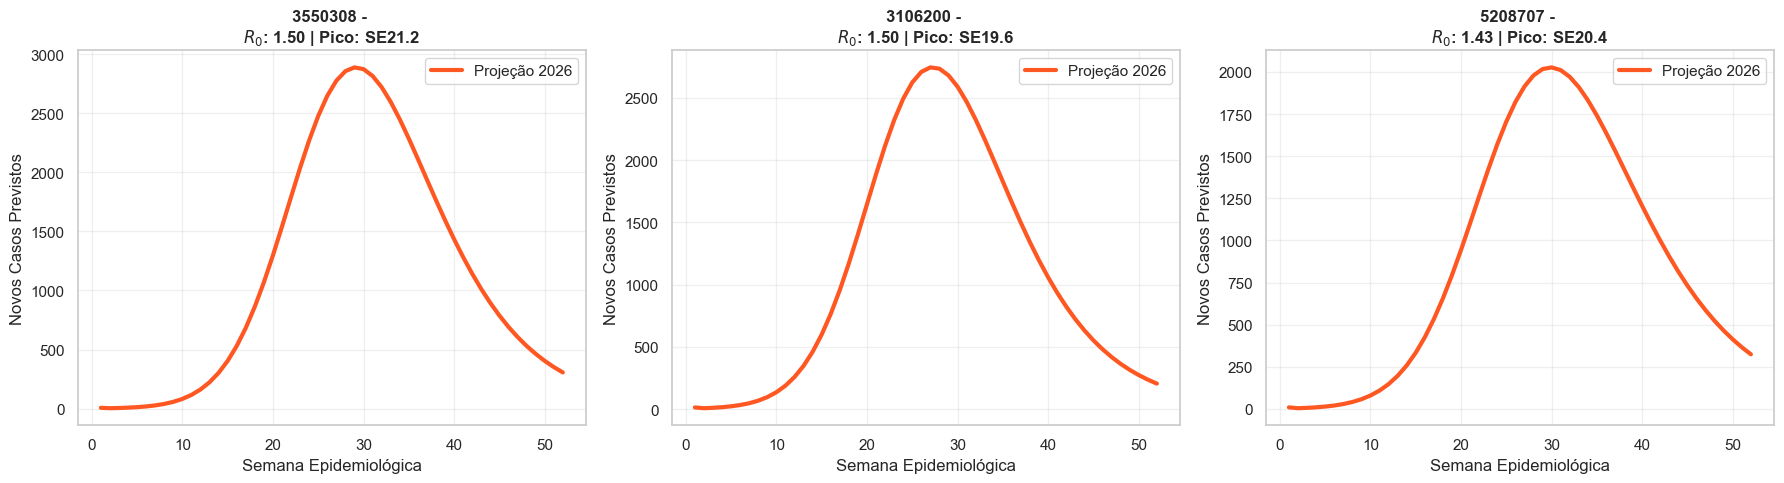

In [16]:

def plot_2026_forecasts(results_df, n=3):
    """Plota as curvas previstas para o futuro."""

    # Seleciona as piores epidemias previstas (maior R0) para mostrar
    top_risks = results_df.sort_values('Pred_Total_Cases', ascending=False).head(n)

    weeks = np.arange(1, 53)

    plt.figure(figsize=(18, 5), facecolor='white')

    for i, (idx, row) in enumerate(top_risks.iterrows()):
        # Parâmetros
        L = row['Pred_Total_Cases']
        tp = row['Pred_Peak_Week']
        a = row['Pred_Alpha']
        b = row['Pred_Beta']

        # Reconstruir Curva de Incidência (Derivada de Richards)
        # b_calc = beta * alpha
        b_calc = b * a
        exponent = -b_calc * (weeks - tp)
        denom = 1 + np.exp(np.clip(exponent, -100, 100))
        J_t = L * (denom ** (-1.0 / a))
        inc = np.diff(J_t, prepend=0)

        # Plot
        city_name = row['geocode_name'] if 'geocode_name' in row else row['geocode']
        uf = row['uf'] if 'uf' in row else ""

        plt.subplot(1, n, i+1)
        plt.plot(weeks, inc, color='#FF5722', linewidth=3, label='Projeção 2026')

        title = f"{city_name} - {uf}\n$R_0$: {row['Pred_R0']:.2f} | Pico: SE{tp:.1f}"
        plt.title(title, fontsize=12, fontweight='bold')
        plt.xlabel("Semana Epidemiológica")
        plt.ylabel("Novos Casos Previstos")
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

# Usar após gerar o df_2026
if 'df_2026' in locals() and df_2026 is not None:
    plot_2026_forecasts(df_2026, n=3)

In [17]:


# Configuração de Estilo
sns.set_theme(style="whitegrid")

# 1. Carregar Resultados
# df_2026 = pd.read_csv("previsoes_dengue_2026.csv") # Se salvou antes
# Ou use a variável 'forecast_df' que está na memória

# 2. Carregar Mapa
gdf_map = gpd.read_file("../data/raw/data_sprint_2025/shape_muni.gpkg")
gdf_map['geocode'] = gdf_map['geocode'].astype(str).str[:6]
df_2026['geocode_short'] = df_2026['geocode'].astype(str).str[:6]

# 3. Função para Calcular Duração (Largura da Curva)
def calculate_duration(row):
    """
    Reconstrói a curva e conta quantas semanas os casos > limiar.
    Critério do paper: Tempo entre 5% e 95% do acumulado ou casos > X.
    Vamos usar: Largura à meia altura (FWHM) ou intervalo de atividade.
    """
    weeks = np.arange(1, 53)

    # Recalcula incidencia
    L = row['Pred_Total_Cases']
    tp = row['Pred_Peak_Week']
    a = row['Pred_Alpha']
    b = row['Pred_Beta']

    # Fórmula da Derivada Richards (Incidência)
    # b_calc = b * a
    # exponent = -b_calc * (weeks - tp)
    # ... (mesma logica usada nos plots anteriores) ...
    # Simplificação: Usar aproximação estatística se a curva for muito complexa
    # Duração aprox ~ 4 / (beta * alpha) para logística simples
    # Mas vamos tentar reconstruir rápido:

    b_val = b * a
    exponent = np.clip(-b_val * (weeks - tp), -50, 50)
    denom = 1 + np.exp(exponent)
    J_t = L * (denom ** (-1.0 / a))
    inc = np.diff(J_t, prepend=0)

    # Semanas com atividade relevante (> 1% do pico máximo)
    peak_val = inc.max()
    if peak_val < 1: return 0 # Sem epidemia

    active_weeks = inc[inc > (peak_val * 0.05)] # 5% do pico
    return len(active_weeks)

print("📐 Calculando duração estimada das epidemias...")
df_2026['Pred_Duration'] = df_2026.apply(calculate_duration, axis=1)

# Merge com Mapa
gdf_results = gdf_map.merge(df_2026, left_on='geocode', right_on='geocode_short', how='inner')

📐 Calculando duração estimada das epidemias...


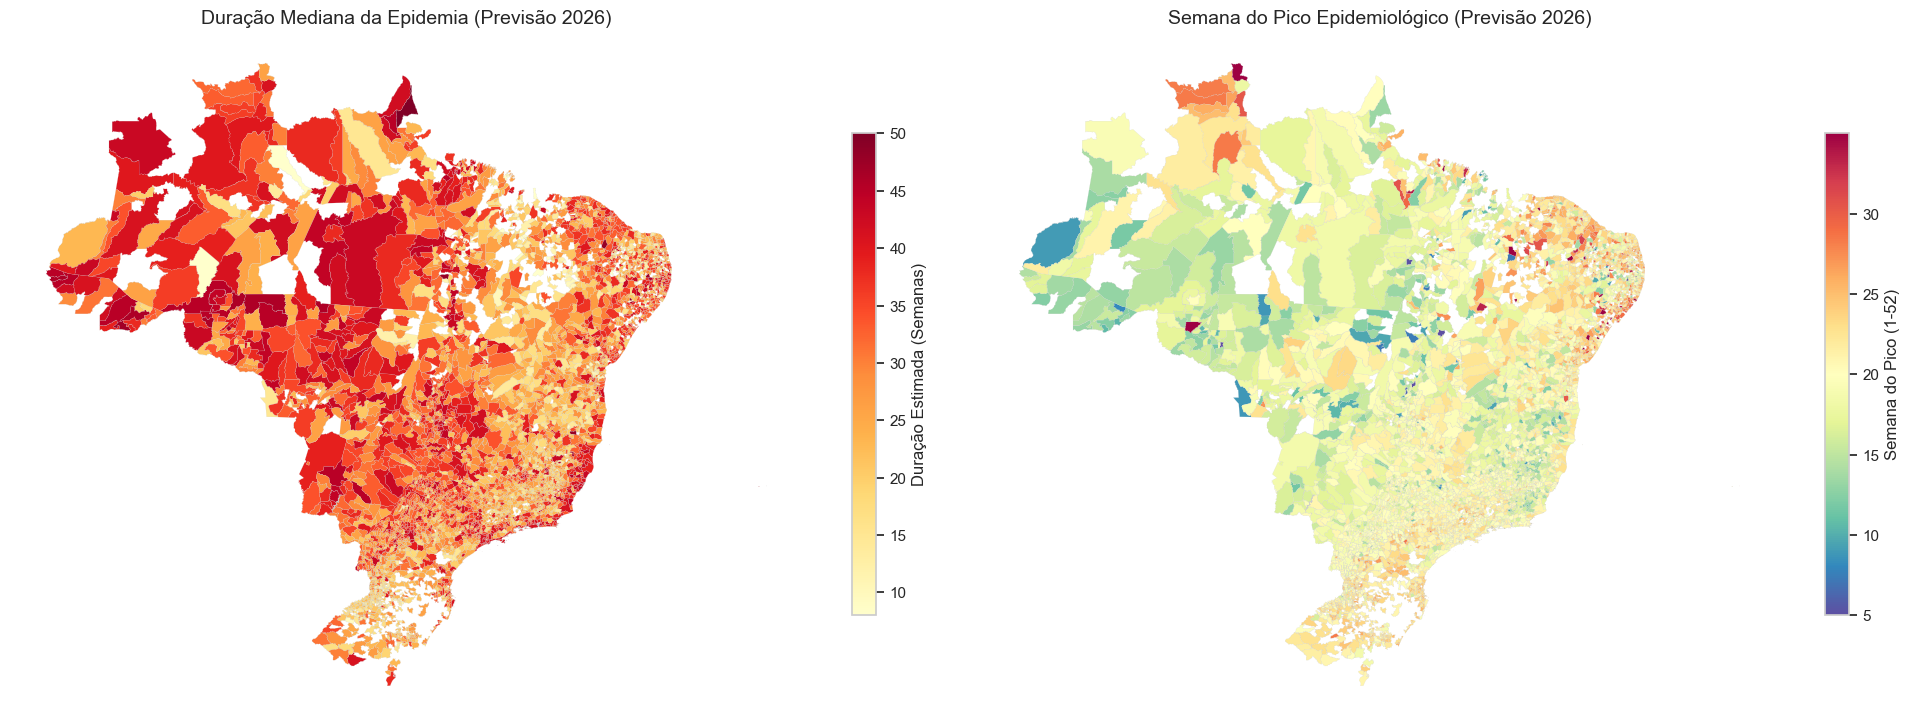

In [18]:
def plot_maps(gdf, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), facecolor='white')

    # Mapa 1: Duração
    gdf.plot(column='Pred_Duration', cmap='YlOrRd', linewidth=0.1, ax=axes[0], edgecolor='0.8', legend=True,
             legend_kwds={'label': "Duração Estimada (Semanas)", 'shrink': 0.5})
    axes[0].set_title("Duração Mediana da Epidemia (Previsão 2026)", fontsize=14)
    axes[0].axis('off')

    # Mapa 2: Semana de Pico
    gdf.plot(column='Pred_Peak_Week', cmap='Spectral_r', linewidth=0.1, ax=axes[1], edgecolor='0.8', legend=True,
             legend_kwds={'label': "Semana do Pico (1-52)", 'shrink': 0.5})
    axes[1].set_title("Semana do Pico Epidemiológico (Previsão 2026)", fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    if save_path is not None: plt.savefig(save_path, dpi=300)
    plt.show()

plot_maps(gdf_results, save_path = "../reports/images/mapas_2026.png")

🔍 Analisando quais capitais o modelo aprendeu melhor...
🏆 As 2 cidades com melhor reconstrução histórica:
  - Porto Velho (RO) (Erro Normalizado: 1.0000)
  - Rio Branco (AC) (Erro Normalizado: 1.0000)


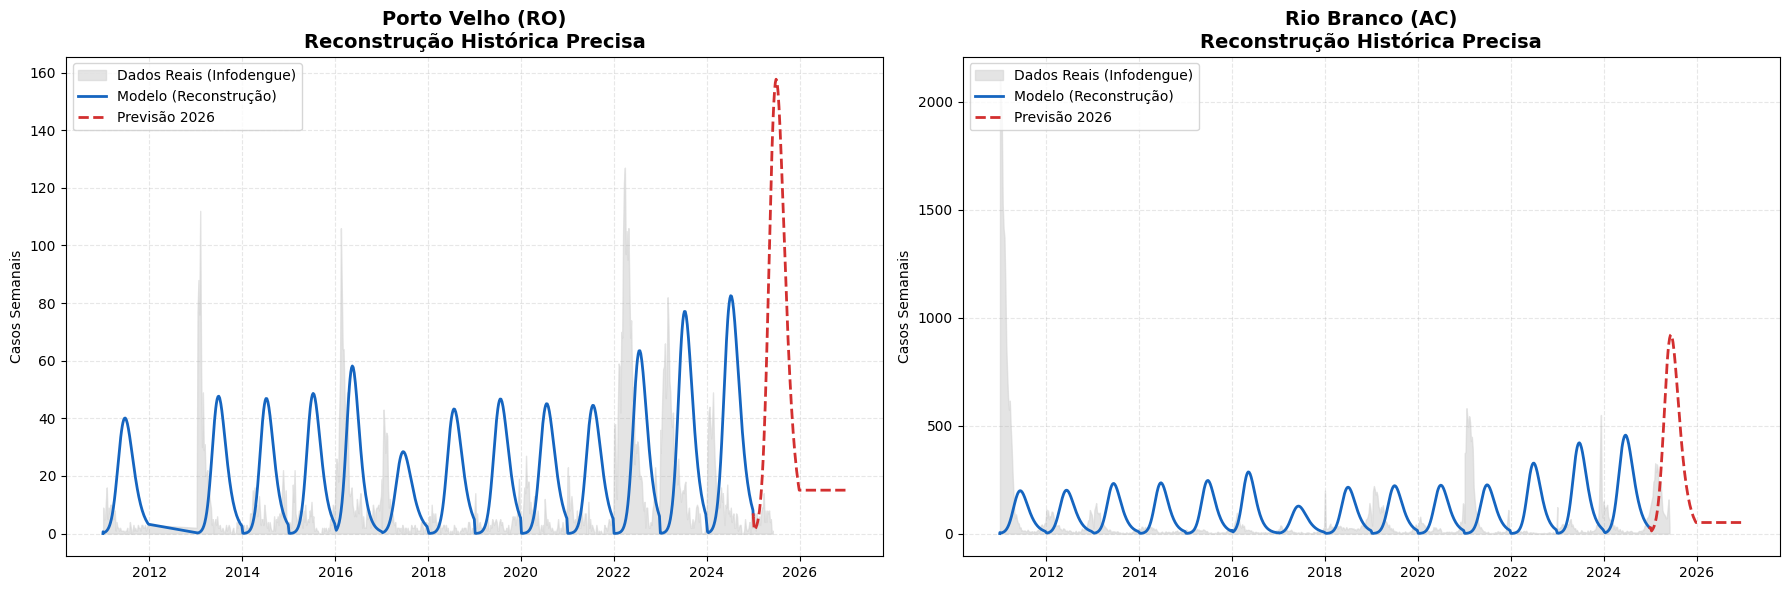

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error

def find_and_plot_best_fits(df_real_all, df_preds_all, capitals, top_n=2):
    print("🔍 Analisando quais capitais o modelo aprendeu melhor...")

    # 1. Tratamento de Datas
    if 'year' in df_real_all.columns and 'week_of_year' in df_real_all.columns:
        dates_rebuilt = pd.to_datetime(
            df_real_all['year'].astype(str) + df_real_all['week_of_year'].astype(str) + '1',
            format='%Y%W%w', errors='coerce'
        )
        df_real_all['date'] = dates_rebuilt

    city_errors = []

    # --- ETAPA 1: CALCULAR ERRO PARA CADA CIDADE ---
    for geocode, city_name in capitals.items():
        # Filtrar dados
        df_real = df_real_all[df_real_all['geocode'] == str(geocode)].sort_values('date')
        df_preds = df_preds_all[df_preds_all['geocode'] == str(geocode)].sort_values('year')

        # Considerar apenas histórico para avaliação (até 2024)
        df_real = df_real[(df_real['date'].dt.year >= 2011) & (df_real['date'].dt.year <= 2024)]

        if df_real.empty: continue

        # Criar linha do tempo comparativa
        comparison_df = df_real[['date', 'casos']].set_index('date').copy()
        comparison_df['model'] = 0.0

        # Reconstruir histórico
        for _, row in df_preds.iterrows():
            year = int(row['year'])
            if year < 2011 or year > 2024: continue # Só histórico

            L = row['Pred_Total']
            tp = row['Pred_Peak']
            a = row['Pred_Alpha']
            b = row['Pred_Beta']

            if L < 10: continue

            try:
                dates = pd.date_range(start=f'{year}-01-01', periods=52, freq='W-SUN')
                t = np.arange(1, 53)
                exponent = -(b * a) * (t - tp)
                denom = 1 + np.exp(np.clip(exponent, -50, 50))
                J_t = L * (denom ** (-1.0 / a))
                inc = np.diff(J_t, prepend=0)

                # Somar na linha do tempo
                temp_series = pd.Series(inc, index=dates)
                common_dates = comparison_df.index.intersection(temp_series.index)
                comparison_df.loc[common_dates, 'model'] += temp_series[common_dates]
            except:
                pass

        # Calcular Erro (MAE normalizado pelo volume de casos para ser justo com cidades grandes)
        # Se a cidade tem muitos casos, o erro absoluto é naturalmente maior. Normalizamos pela média.
        mean_cases = comparison_df['casos'].mean()
        if mean_cases > 10: # Ignorar cidades sem dengue quase nenhuma
            mae = mean_absolute_error(comparison_df['casos'], comparison_df['model'])
            nmae = mae / mean_cases # Normalized MAE
            city_errors.append((geocode, city_name, nmae))

    # Ordenar pelo menor erro (Melhores fits)
    city_errors.sort(key=lambda x: x[2])

    top_cities = city_errors[:top_n]
    print(f"🏆 As {top_n} cidades com melhor reconstrução histórica:")
    for c in top_cities:
        print(f"  - {c[1]} (Erro Normalizado: {c[2]:.4f})")

    # --- ETAPA 2: PLOTAR AS VENCEDORAS ---
    fig, axes = plt.subplots(1, top_n, figsize=(18, 6), facecolor='white')
    if top_n == 1: axes = [axes]

    for i, (geocode, city_name, _) in enumerate(top_cities):
        ax = axes[i]

        # (Reutilizando lógica de plotagem contínua para essas cidades específicas)
        df_real = df_real_all[df_real_all['geocode'] == str(geocode)].sort_values('date')
        df_preds = df_preds_all[df_preds_all['geocode'] == str(geocode)].sort_values('year')
        df_real = df_real[df_real['date'].dt.year >= 2011]

        # Setup Timeline Mestre
        start_date = pd.Timestamp("2011-01-01")
        end_date = pd.Timestamp("2026-12-31")
        master_timeline = pd.DataFrame({'date': pd.date_range(start=start_date, end=end_date, freq='D')}).set_index('date')
        master_timeline['cases_model'] = 0.0

        # Reconstrução
        for _, row in df_preds.iterrows():
            year = int(row['year'])
            if year < 2011: continue

            L = row['Pred_Total']; tp = row['Pred_Peak']; a = row['Pred_Alpha']; b = row['Pred_Beta']
            if L < 10: continue

            try:
                wave_dates = pd.date_range(start=f'{year}-01-01', periods=52, freq='W-SUN')
                t = np.arange(1, 53)
                exponent = np.clip(-(b * a) * (t - tp), -50, 50)
                J_t = L * (1 + np.exp(exponent)) ** (-1.0 / a)
                inc = np.diff(J_t, prepend=0)

                temp_series = pd.Series(inc, index=wave_dates)
                common = master_timeline.index.intersection(temp_series.index)
                master_timeline.loc[common, 'cases_model'] += temp_series[common]
            except: pass

        # Interpolação para suavizar
        master_timeline['cases_model'] = master_timeline['cases_model'].replace(0, np.nan).interpolate(method='time').fillna(0)

        # PLOT
        # Área Real
        ax.fill_between(df_real['date'], df_real['casos'], color='lightgray', alpha=0.6, label='Dados Reais (Infodengue)')

        # Linha Modelo (Histórico)
        split_date = pd.Timestamp("2025-01-01")
        hist_data = master_timeline[master_timeline.index < split_date]
        ax.plot(hist_data.index, hist_data['cases_model'], color='#1565C0', lw=2, label='Modelo (Reconstrução)')

        # Linha Modelo (Futuro - Opcional, mas legal mostrar a continuidade)
        fut_data = master_timeline[master_timeline.index >= split_date]
        if not hist_data.empty and not fut_data.empty:
            connector = pd.concat([hist_data.iloc[[-1]], fut_data.iloc[[0]]])
            ax.plot(connector.index, connector['cases_model'], color='#D32F2F', ls='-', lw=2)
        ax.plot(fut_data.index, fut_data['cases_model'], color='#D32F2F', ls='--', lw=2, label='Previsão 2026')

        # Estética
        ax.set_title(f"{city_name}\nReconstrução Histórica Precisa", fontsize=14, fontweight='bold')
        ax.xaxis.set_major_locator(mdates.YearLocator(2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend(loc='upper left')
        ax.set_ylabel("Casos Semanais")

    plt.tight_layout()
    plt.savefig("slide7_melhores_reconstrucoes.png", dpi=150, facecolor='white')
    plt.show()

# --- EXECUÇÃO ---
# Certifique-se que df_all_preds (o dataframe unificado) está na memória
if 'all_predictions' in locals():
    find_and_plot_best_fits(data_inference, all_predictions, CAPITAIS_BR)
else:
    print("⚠️ Rode 'generate_full_history_predictions' primeiro para ter 'df_all_preds'.")

In [19]:
def generate_summary_table(df):
    cols = ['Pred_R0', 'Pred_Duration', 'Pred_Peak_Week', 'Pred_Total_Cases']

    summary = df[cols].describe().T
    summary = summary[['mean', 'std', '25%', '50%', '75%']]
    summary.columns = ['Média', 'Desvio Padrão', 'Q1 (25%)', 'Mediana', 'Q3 (75%)']

    print("\n📊 Estatísticas Sumárias (Previsão 2026):")
    display(summary)

    # Salvar para LaTeX
    print("\nCódigo LaTeX:")
    print(summary.to_latex(float_format="%.2f"))

generate_summary_table(df_2026)


📊 Estatísticas Sumárias (Previsão 2026):


Média  Desvio Padrão    Q1 (25%)     Mediana  \
Pred_R0             1.949322       0.424407    1.662779    1.855164   
Pred_Duration      27.604636       8.187919   22.000000   27.000000   
Pred_Peak_Week     20.078466       3.659591   18.011553   20.112312   
Pred_Total_Cases  685.564070    2248.942907  168.000000  303.000000   

                    Q3 (75%)  
Pred_R0             2.116250  
Pred_Duration      34.000000  
Pred_Peak_Week     22.134552  
Pred_Total_Cases  576.500000


Código LaTeX:
\begin{tabular}{lrrrrr}
\toprule
 & Média & Desvio Padrão & Q1 (25%) & Mediana & Q3 (75%) \\
\midrule
Pred_R0 & 1.95 & 0.42 & 1.66 & 1.86 & 2.12 \\
Pred_Duration & 27.60 & 8.19 & 22.00 & 27.00 & 34.00 \\
Pred_Peak_Week & 20.08 & 3.66 & 18.01 & 20.11 & 22.13 \\
Pred_Total_Cases & 685.56 & 2248.94 & 168.00 & 303.00 & 576.50 \\
\bottomrule
\end{tabular}



🔗 Adicionando Macroregião ao dataframe de 2026...


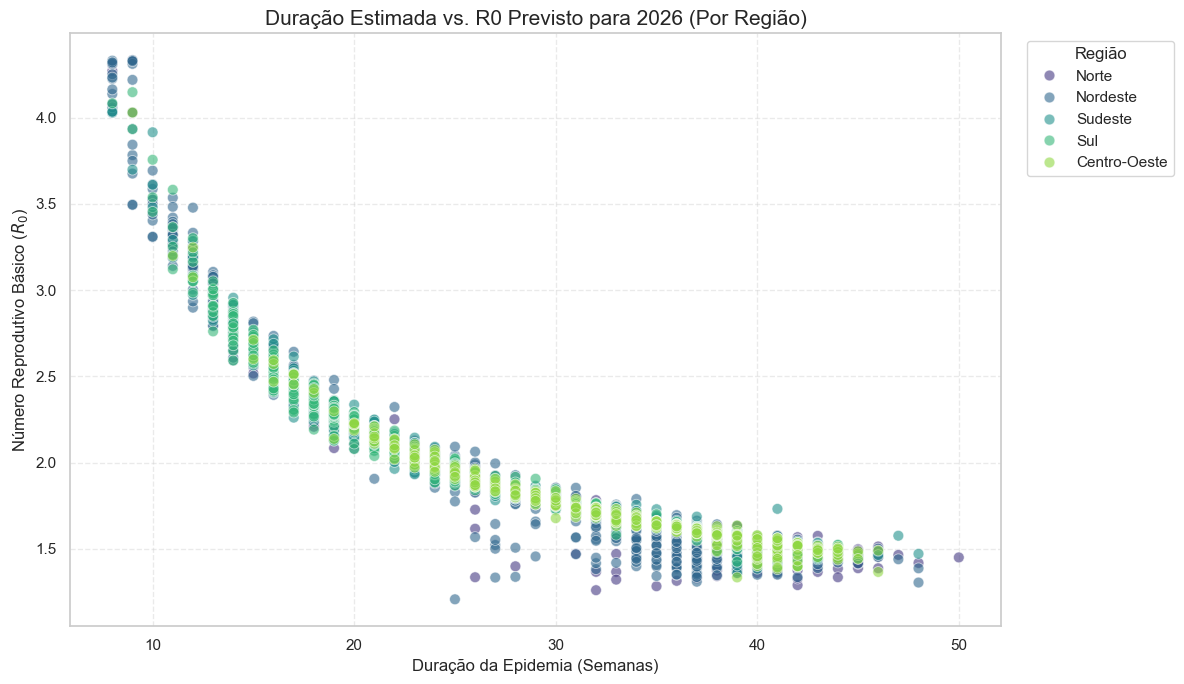

In [20]:

# 1. Carregar o arquivo de regiões (Se ainda não estiver na memória)
# Ajuste o caminho se necessário (/content/ ou /kaggle/input/...)
path_regioes = "../data/raw/data_sprint_2025/map_regional_health.csv"
# Se estiver no Kaggle/Colab e não tiver o arquivo solto, use o caminho completo:
# path_regioes = "/kaggle/input/dengue-dataset/map_regional_health.csv"

try:
    df_regions = pd.read_csv(path_regioes)
except FileNotFoundError:
    # Tenta achar no diretório atual ou subdiretórios comuns
    import glob
    candidates = glob.glob("**/map_regional_health.csv", recursive=True)
    if candidates:
        df_regions = pd.read_csv(candidates[0])
    else:
        print("❌ Erro: Arquivo 'map_regional_health.csv' não encontrado.")
        # Cria uma coluna dummy para o código não quebrar, se não achar o arquivo
        df_2026['macroregion_name'] = 'Desconhecido'
        df_regions = None

if df_regions is not None:
    # 2. Preparar para o Merge
    # Garantir que geocode é string em ambos para bater
    df_2026['geocode'] = df_2026['geocode'].astype(str)
    df_regions['geocode'] = df_regions['geocode'].astype(str)

    # 3. Realizar o Merge
    # Trazemos apenas a coluna 'macroregion_name'
    print("🔗 Adicionando Macroregião ao dataframe de 2026...")
    df_2026 = df_2026.merge(
        df_regions[['geocode', 'macroregion_name']],
        on='geocode',
        how='left'
    )

    # Preencher nulos se houver
    df_2026['macroregion_name'] = df_2026['macroregion_name'].fillna('Outros')

# --- 4. PLOTAR AGORA QUE A COLUNA EXISTE ---

def plot_duration_vs_r0(df, save_path=None):
    plt.figure(figsize=(12, 7), facecolor='white')

    sns.scatterplot(
        data=df,
        x='Pred_Duration',
        y='Pred_R0',
        hue='macroregion_name',
        alpha=0.6,
        palette='viridis',
        s=60 # Tamanho da bolinha
    )

    plt.title("Duração Estimada vs. R0 Previsto para 2026 (Por Região)", fontsize=15)
    plt.xlabel("Duração da Epidemia (Semanas)", fontsize=12)
    plt.ylabel("Número Reprodutivo Básico ($R_0$)", fontsize=12)

    # Legenda fora do gráfico para não tampar dados
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Região")

    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()

    if save_path is not None: plt.savefig(save_path, dpi=300)

    plt.show()

# Executar
if 'Pred_Duration' not in df_2026.columns:
    print("⚠️ Calcule a duração primeiro (código enviado anteriormente)!")
else:
    plot_duration_vs_r0(df_2026, save_path="../reports/images/r0_2026.png")

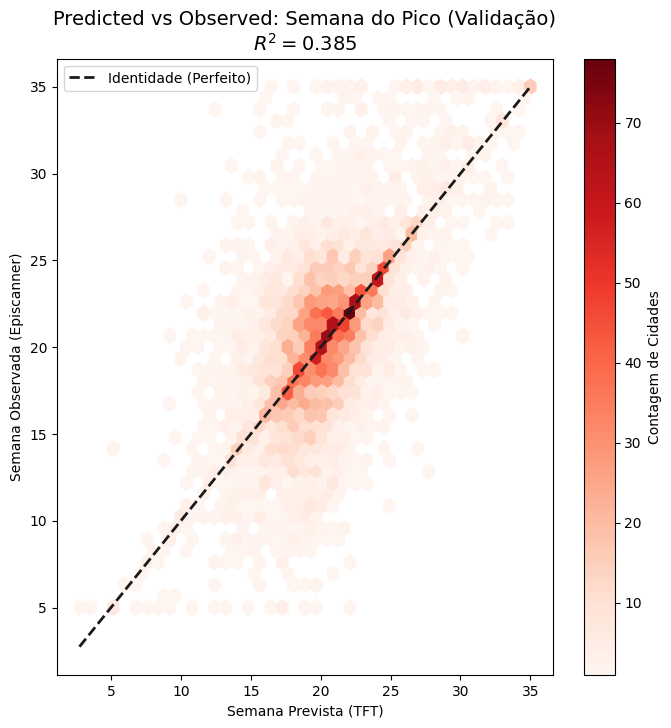

In [36]:
def plot_predicted_vs_observed(preds, targets, target_names, save_path=None):
    # Encontrar índice do Pico (Peak Week)
    idx_peak = target_names.index("peak_week")

    y_pred = preds[idx_peak].cpu().numpy().flatten()
    y_true = targets[0][idx_peak].cpu().numpy().flatten()

    plt.figure(figsize=(8, 8), facecolor='white')

    # Hexbin é melhor que scatter para muitos pontos
    plt.hexbin(y_pred, y_true, gridsize=40, cmap='Reds', mincnt=1)
    plt.colorbar(label='Contagem de Cidades')

    # Linha de Identidade
    min_val = min(y_pred.min(), y_true.min())
    max_val = max(y_pred.max(), y_true.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Identidade (Perfeito)')

    r2 = r2_score(y_true, y_pred)

    plt.title(f"Predicted vs Observed: Semana do Pico (Validação)\n$R^2 = {r2:.3f}$", fontsize=14)
    plt.xlabel("Semana Prevista (TFT)")
    plt.ylabel("Semana Observada (Episcanner)")
    plt.legend()

    if save_path is not None: plt.savefig(save_path, dpi=300)

    plt.show()

# Usar as variaveis do script de teste anterior
plot_predicted_vs_observed(predictions, ground_truth, TARGETS, save_path="../reports/images/pred_vs_obs_2026.png")

🔍 Gerando Gráficos de Importância (Estrutura Plana)...

📊 Renderizando...


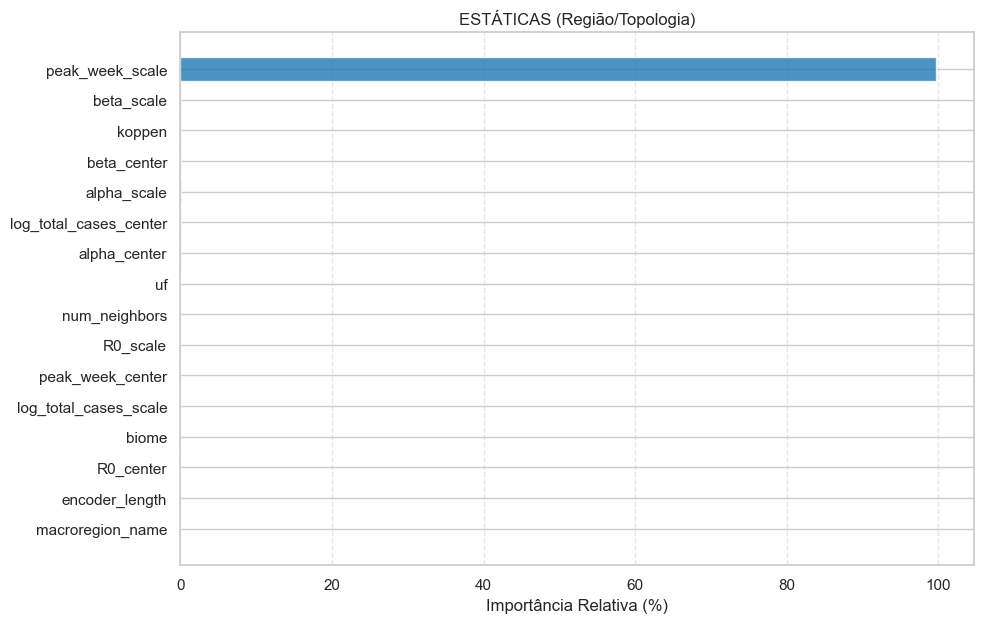

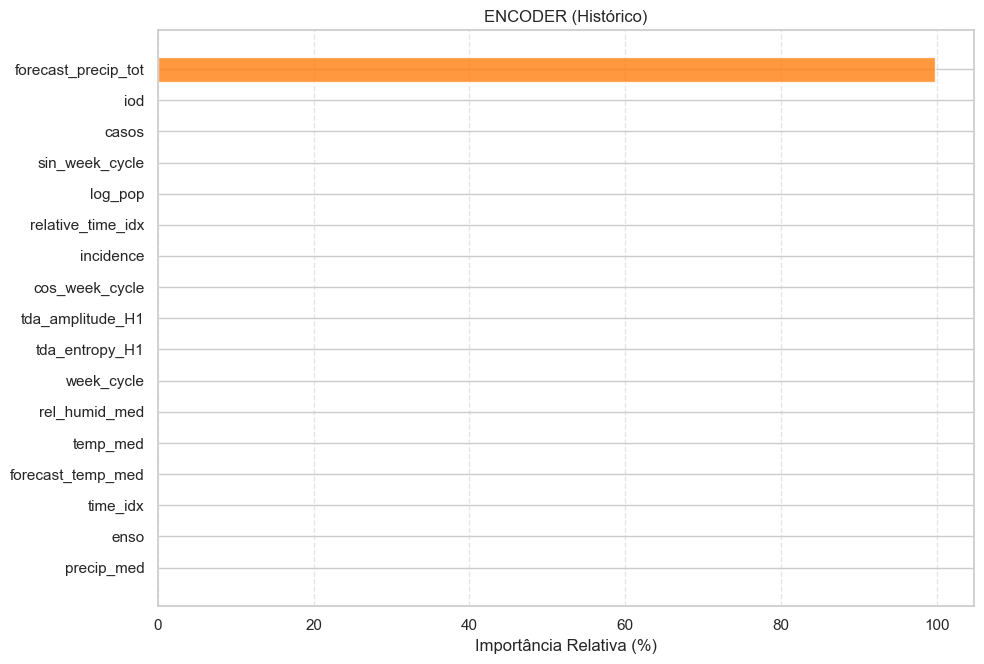

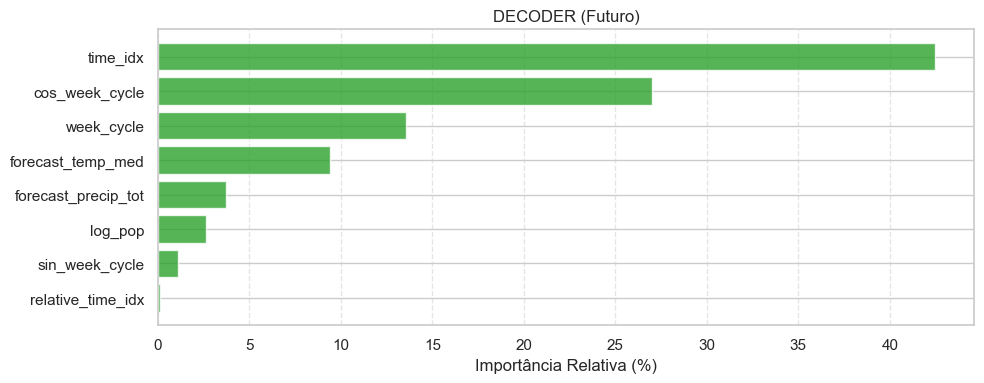

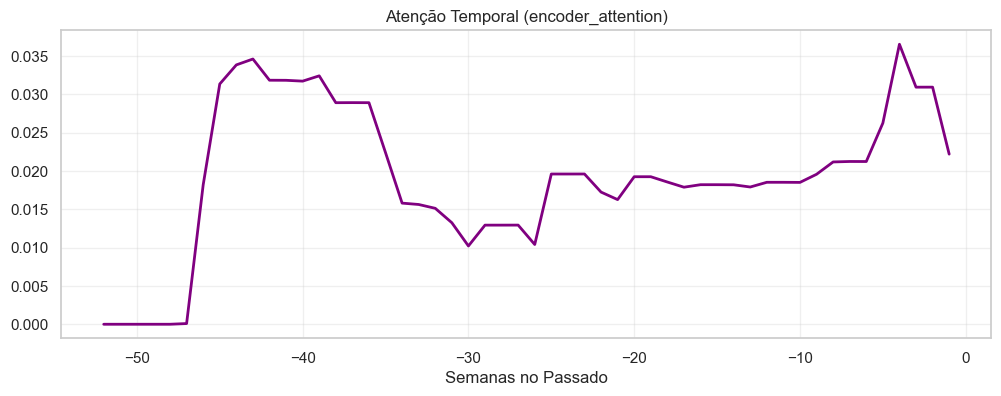

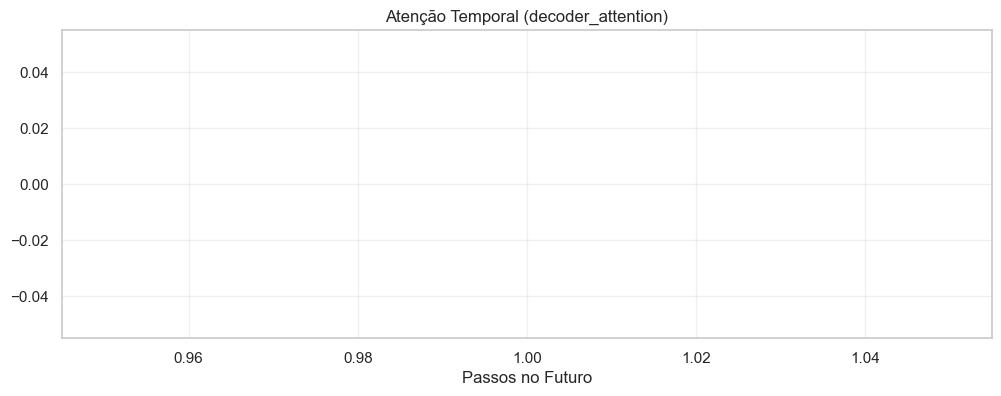

In [22]:


def plot_feature_importance(model, dataloader):
    print("🔍 Gerando Gráficos de Importância (Estrutura Plana)...")
    model.eval()

    # 1. Pegar Batch
    try:
        raw_batch = next(iter(dataloader))
        x = raw_batch[0] if isinstance(raw_batch, (list, tuple)) else raw_batch

        device = model.device
        for key in x.keys():
            if hasattr(x[key], "to"):
                x[key] = x[key].to(device)

        # 2. Forward Pass
        with torch.no_grad():
            raw_output = model(x)

        # --- CORREÇÃO: O output JÁ É a interpretação ---
        # Convertemos para dicionário para facilitar o acesso
        if hasattr(raw_output, 'to_dict'):
            interpretation = raw_output.to_dict()
        elif hasattr(raw_output, '_asdict'):
            interpretation = raw_output._asdict()
        elif isinstance(raw_output, dict):
            interpretation = raw_output
        else:
            # Fallback para objetos que se comportam como dict mas não são
            # (O log mostrou que ele tem as chaves, então getattr deve funcionar ou acesso direto)
            interpretation = raw_output

    except Exception as e:
        print(f"❌ Erro na extração: {e}")
        return

    # 3. Função de Plotagem
    def plot_bars(key_name, feature_names, title, color):
        # Tenta acessar como dict ou atributo
        try:
            if isinstance(interpretation, dict):
                if key_name not in interpretation: return
                tensor_data = interpretation[key_name]
            else:
                if not hasattr(interpretation, key_name): return
                tensor_data = getattr(interpretation, key_name)
        except:
            return

        # Processar Tensor
        weights = tensor_data.detach().cpu().numpy()

        # Reduzir dimensões (Batch/Time -> Features)
        while weights.ndim > 1:
            weights = weights.sum(axis=0)

        # Normalizar
        total = weights.sum()
        if total > 0: weights = weights / total * 100

        # Nomes (Fallback se não bater o tamanho)
        if len(feature_names) != len(weights):
            feature_names = [f"F{i}" for i in range(len(weights))]

        # Plot
        indices = np.argsort(weights)
        sorted_weights = weights[indices]
        sorted_names = [feature_names[i] for i in indices]

        plt.figure(figsize=(10, max(4, len(sorted_names) * 0.4)), facecolor='white')
        plt.barh(range(len(sorted_weights)), sorted_weights, color=color, alpha=0.8)
        plt.yticks(range(len(sorted_weights)), sorted_names)
        plt.xlabel("Importância Relativa (%)")
        plt.title(title)
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    # --- 4. GERAR GRÁFICOS ---
    print("\n📊 Renderizando...")

    plot_bars("static_variables", model.static_variables, "ESTÁTICAS (Região/Topologia)", "#1f77b4")
    plot_bars("encoder_variables", model.encoder_variables, "ENCODER (Histórico)", "#ff7f0e")
    plot_bars("decoder_variables", model.decoder_variables, "DECODER (Futuro)", "#2ca02c")

    # Atenção Temporal
    # O log mostrou que as chaves são 'encoder_attention' e 'decoder_attention'
    for key in ['encoder_attention', 'decoder_attention']:
        if isinstance(interpretation, dict):
            attn = interpretation.get(key)
        else:
            attn = getattr(interpretation, key, None)

        if attn is not None:
            attn_vals = attn.detach().cpu().numpy()
            # Reduzir (Batch, Time, Heads) -> (Time)
            while attn_vals.ndim > 1:
                attn_vals = attn_vals.mean(axis=0)

            plt.figure(figsize=(12, 4), facecolor='white')
            # Eixo X depende se é encoder (passado) ou decoder (futuro)
            if 'encoder' in key:
                x_axis = np.arange(-len(attn_vals), 0)
                label = "Semanas no Passado"
            else:
                x_axis = np.arange(1, len(attn_vals) + 1)
                label = "Passos no Futuro"

            plt.plot(x_axis, attn_vals, color='purple', linewidth=2)
            plt.title(f"Atenção Temporal ({key})")
            plt.xlabel(label)
            plt.grid(True, alpha=0.3)
            plt.show()

# --- EXECUÇÃO ---
plot_feature_importance(best_tft, val_dataloader)

In [23]:
# Dicionário oficial de Capitais (IBGE 7 Dígitos)
CAPITAIS_BR = {
    '1100205': 'Porto Velho (RO)',
    '1200401': 'Rio Branco (AC)',
    '1302603': 'Manaus (AM)',
    '1400100': 'Boa Vista (RR)',
    '1501402': 'Belém (PA)',
    '1600303': 'Macapá (AP)',
    '1721000': 'Palmas (TO)',
    '2111300': 'São Luís (MA)',
    '2211001': 'Teresina (PI)',
    '2304400': 'Fortaleza (CE)',
    '2408102': 'Natal (RN)',
    '2507507': 'João Pessoa (PB)',
    '2611606': 'Recife (PE)',
    '2704302': 'Maceió (AL)',
    '2800308': 'Aracaju (SE)',
    '2927408': 'Salvador (BA)',
    '3106200': 'Belo Horizonte (MG)',
    '3205309': 'Vitória (ES)',
    '3304557': 'Rio de Janeiro (RJ)',
    '3550308': 'São Paulo (SP)',
    '4106902': 'Curitiba (PR)',
    '4205407': 'Florianópolis (SC)',
    '4314902': 'Porto Alegre (RS)',
    '5002704': 'Campo Grande (MS)',
    '5103403': 'Cuiabá (MT)',
    '5208707': 'Goiânia (GO)',
    '5300108': 'Brasília (DF)'
}

In [24]:
def predict_all_years_capitals(model, full_data, capitals_dict):
    print("🚀 Gerando histórico de previsões para as 27 Capitais...")

    # 1. Filtrar apenas as Capitais
    # Garante que o geocode é string para bater com o dicionário
    full_data['geocode'] = full_data['geocode'].astype(str)
    df_caps = full_data[full_data['geocode'].isin(capitals_dict.keys())].copy()

    print(f"   - Linhas filtradas: {len(df_caps)}")

    # 2. Criar Dataset de Inferência
    # predict_mode=False permite que o modelo gere output para toda a série temporal
    # mas aqui usaremos uma estratégia de janela deslizante manual ou predict direto

    # Para ser eficiente e pegar um valor por ano, vamos agrupar por Ano/Cidade
    # e pegar a última semana de cada ano para fazer a previsão daquele ano
    # (Simulando que estamos no fim do ano ou olhando o ano todo)

    # Estratégia Melhor: Passar tudo para o Dataloader e pegar as predições sequenciais
    try:
        dataset = TimeSeriesDataSet.from_parameters(
            model.dataset_parameters,
            df_caps,
            predict=True,
            stop_randomization=True
        )
    except:
        # Fallback se der erro de atributo (recria manual)
        print("⚠️ Recriando dataset manualmente...")
        from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer
        # (Copie aqui a config do target_normalizer se cair neste bloco)
        # Assumindo que vai funcionar com from_parameters pois carregamos o modelo certo
        return None

    dataloader = dataset.to_dataloader(train=False, batch_size=128, num_workers=0)

    # 3. Previsão em Lote
    print("🧠 Executando inferência em lote (pode demorar um pouco)...")
    raw_predictions = model.predict(dataloader, mode="prediction", return_index=True)

    preds = raw_predictions.output
    index = raw_predictions.index # contem time_idx e geocode

    # 4. Consolidar Resultados
    results = pd.DataFrame()
    results['geocode'] = index['geocode']
    results['time_idx'] = index['time_idx']

    # Cruzar com o dado original para pegar o ANO real daquela previsão
    # (O time_idx do index é o tempo do decoder/previsão)
    idx_lookup = df_caps[['time_idx', 'geocode', 'year']].drop_duplicates()
    results = results.merge(idx_lookup, on=['time_idx', 'geocode'], how='left')

    # Extrair Parâmetros Previstos
    results['Pred_R0'] = preds[0].cpu().numpy().flatten()
    results['Pred_Peak'] = preds[1].cpu().numpy().flatten()
    results['Pred_Total'] = np.expm1(preds[2].cpu().numpy().flatten())
    if len(preds) > 3:
        results['Pred_Alpha'] = preds[3].cpu().numpy().flatten()
        results['Pred_Beta'] = preds[4].cpu().numpy().flatten()

    # Como o modelo gera uma previsão por semana (janela deslizante),
    # vamos tirar a MÉDIA das previsões para cada Ano.
    # Ex: Todas as semanas de 2015 vão votar em qual foi o R0 de 2015.
    annual_preds = results.groupby(['geocode', 'year'])[[
        'Pred_R0', 'Pred_Peak', 'Pred_Total', 'Pred_Alpha', 'Pred_Beta'
    ]].median().reset_index()

    return annual_preds

# --- EXECUÇÃO ---
df_capitals_preds = predict_all_years_capitals(best_tft, data_inference, CAPITAIS_BR)

🚀 Gerando histórico de previsões para as 27 Capitais...
   - Linhas filtradas: 19500


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🧠 Executando inferência em lote (pode demorar um pouco)...


In [25]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from pytorch_forecasting import TimeSeriesDataSet

# --- 1. FUNÇÃO DE GERAÇÃO ROBUSTA (HISTÓRICO + FUTURO) ---
def generate_full_history_predictions(model, data, capitals):
    print("🚀 Iniciando reconstrução total (2010-2026)...")

    # Filtrar apenas capitais
    data = data.copy()
    data['geocode'] = data['geocode'].astype(str)
    data_caps = data[data['geocode'].isin(capitals.keys())].copy()

    # ---------------------------------------------------------
    # PARTE A: HISTÓRICO (2010-2024)
    # ---------------------------------------------------------
    print("⏳ Processando histórico (Janela Deslizante)...")

    # MUDANÇA CRUCIAL: predict_mode=False
    # Isso força o modelo a gerar previsões para TODAS as janelas deslizantes possíveis no passado
    dataset_hist = TimeSeriesDataSet.from_parameters(
        model.dataset_parameters,
        data_caps,
        predict=False,  # <--- O SEGREDO ESTÁ AQUI
        stop_randomization=True
    )

    loader_hist = dataset_hist.to_dataloader(train=False, batch_size=128, num_workers=0)

    # Previsão
    raw_hist = model.predict(loader_hist, mode="prediction", return_index=True)
    preds_hist = raw_hist.output
    index_hist = raw_hist.index

    # Organizar Histórico
    df_hist = pd.DataFrame()
    df_hist['geocode'] = index_hist['geocode']
    df_hist['time_idx'] = index_hist['time_idx']

    # Cruzar com ano real
    lookup = data_caps[['time_idx', 'geocode', 'year']].drop_duplicates()
    df_hist = df_hist.merge(lookup, on=['time_idx', 'geocode'], how='left')

    # Extrair valores
    df_hist['Pred_R0'] = preds_hist[0].cpu().numpy().flatten()
    df_hist['Pred_Peak'] = preds_hist[1].cpu().numpy().flatten()
    df_hist['Pred_Total'] = np.expm1(preds_hist[2].cpu().numpy().flatten())
    df_hist['Pred_Alpha'] = preds_hist[3].cpu().numpy().flatten()
    df_hist['Pred_Beta'] = preds_hist[4].cpu().numpy().flatten()

    # AGREGAR POR ANO: Como a janela desliza, temos ~52 previsões para o mesmo ano.
    # Pegamos a mediana para ter uma estimativa robusta daquele ano.
    df_hist_final = df_hist.groupby(['geocode', 'year']).median().reset_index()

    # ---------------------------------------------------------
    # PARTE B: FUTURO (2025/2026) - COLD START
    # ---------------------------------------------------------
    print("🔮 Projetando cenário futuro (Cold Start)...")

    # Pega o último pedaço de dados disponível para cada cidade
    last_rows = data_caps.sort_values("time_idx").groupby("geocode").tail(1).copy()
    future_rows = last_rows.copy()
    future_rows['time_idx'] += 1
    future_rows['year'] += 1 # Avança para o próximo ano inédito

    # Zera targets
    for c in ["casos", "incidence", "tda_entropy_H1", "tda_amplitude_H1"]:
        if c in future_rows.columns: future_rows[c] = 0.0

    # Concatena para dar contexto
    combined_future = pd.concat([data_caps, future_rows], ignore_index=True).sort_values(['geocode', 'time_idx'])

    # Dataset específico para o último passo (predict=True aqui é correto)
    ds_fut = TimeSeriesDataSet.from_parameters(
        model.dataset_parameters,
        combined_future,
        predict=True,
        stop_randomization=True
    )
    dl_fut = ds_fut.to_dataloader(train=False, batch_size=64, num_workers=0)

    raw_fut = model.predict(dl_fut, mode="prediction", return_index=True)
    preds_fut = raw_fut.output
    idx_fut = raw_fut.index

    df_fut = pd.DataFrame()
    df_fut['geocode'] = idx_fut['geocode']
    df_fut['year'] = future_rows['year'].iloc[0] # Ano projetado

    df_fut['Pred_R0'] = preds_fut[0].cpu().numpy().flatten()
    df_fut['Pred_Peak'] = preds_fut[1].cpu().numpy().flatten()
    df_fut['Pred_Total'] = np.expm1(preds_fut[2].cpu().numpy().flatten())
    df_fut['Pred_Alpha'] = preds_fut[3].cpu().numpy().flatten()
    df_fut['Pred_Beta'] = preds_fut[4].cpu().numpy().flatten()

    # ---------------------------------------------------------
    # UNIFICAR
    # ---------------------------------------------------------
    final_df = pd.concat([df_hist_final, df_fut], ignore_index=True)
    final_df = final_df.sort_values(['geocode', 'year'])

    print(f"✅ Concluído! Temos previsões para os anos: {final_df['year'].unique()}")
    return final_df

# --- 2. PLOTAGEM ATUALIZADA ---
def plot_full_history(df_real_all, df_preds_all, capitals, output_folder="resultados_capitais_full"):
    if not os.path.exists(output_folder): os.makedirs(output_folder)

    # Correção de Datas no Real
    if 'year' in df_real_all.columns and 'week_of_year' in df_real_all.columns:
        dates_rebuilt = pd.to_datetime(
            df_real_all['year'].astype(str) + df_real_all['week_of_year'].astype(str) + '1',
            format='%Y%W%w', errors='coerce'
        )
        df_real_all['date'] = dates_rebuilt

    for geocode, city_name in capitals.items():
        # Dados Reais
        df_real = df_real_all[df_real_all['geocode'] == str(geocode)].sort_values('date')
        df_preds = df_preds_all[df_preds_all['geocode'] == str(geocode)].sort_values('year')

        # Filtro de ano visual
        df_real = df_real[df_real['date'].dt.year >= 2011]

        if df_real.empty: continue

        fig, ax = plt.subplots(figsize=(16, 6), facecolor='white')

        # 1. Plot Real (Fundo)
        ax.fill_between(df_real['date'], df_real['casos'], color='#E0E0E0', alpha=0.6, label='Notificado (Real)')
        ax.plot(df_real['date'], df_real['casos'], color='gray', lw=0.8, alpha=0.5)

        # --- MUDANÇA: ACUMULADORES DE DADOS ---
        # Vamos guardar todos os pontos (x, y) do histórico e do futuro separadamente
        hist_dates, hist_values = [], []
        fut_dates, fut_values = [], []

        # Dicionário para guardar anotações de R0 (Data, ValorY, Texto, Cor)
        annotations = []

        for _, row in df_preds.iterrows():
            year = int(row['year'])
            if year < 2011: continue

            L = row['Pred_Total']
            tp = row['Pred_Peak']
            a = row['Pred_Alpha']
            b = row['Pred_Beta']

            # Se epidemia for muito pequena, adicionamos zeros para manter a linha no chão
            # Isso evita buracos onde o modelo previu "nada"
            if L < 50:
                try:
                    dates = pd.date_range(start=f'{year}-01-01', periods=52, freq='W-SUN')
                    zeros = np.zeros(52)
                    if year >= 2025:
                        fut_dates.extend(dates)
                        fut_values.extend(zeros)
                    else:
                        hist_dates.extend(dates)
                        hist_values.extend(zeros)
                except: pass
                continue

            try:
                # Datas
                dates = pd.date_range(start=f'{year}-01-01', periods=52, freq='W-SUN')

                # Curva Richards
                t = np.arange(1, 53)
                exponent = -(b * a) * (t - tp)
                denom = 1 + np.exp(np.clip(exponent, -50, 50))
                J_t = L * (denom ** (-1.0 / a))
                inc = np.diff(J_t, prepend=0)

                # Separar Passado e Futuro
                if year >= 2025:
                    fut_dates.extend(dates)
                    fut_values.extend(inc)
                    # Guardar pico para anotação
                    if inc.max() > 10:
                        peak_idx = np.argmax(inc)
                        annotations.append((dates[peak_idx], inc[peak_idx], f"R0 {row['Pred_R0']:.1f}", 'darkred'))
                else:
                    hist_dates.extend(dates)
                    hist_values.extend(inc)
                    # Guardar pico para anotação (opcional para histórico, filtro mais alto)
                    if inc.max() > df_real['casos'].max() * 0.2:
                        peak_idx = np.argmax(inc)
                        annotations.append((dates[peak_idx], inc[peak_idx], f"{row['Pred_R0']:.1f}", '#1565C0'))

            except:
                pass

        # --- PLOTAGEM DAS LINHAS UNIFICADAS ---

        # Linha Histórica (Azul Sólido)
        if hist_dates:
            # Ordenar por data para garantir linha correta
            hist_df = pd.DataFrame({'date': hist_dates, 'val': hist_values}).sort_values('date')
            ax.plot(hist_df['date'], hist_df['val'], color='#1976D2', lw=1.5, alpha=0.9, label='Modelo (Reconstrução)')

        # Linha Futura (Vermelha Tracejada)
        if fut_dates:
            fut_df = pd.DataFrame({'date': fut_dates, 'val': fut_values}).sort_values('date')
            ax.plot(fut_df['date'], fut_df['val'], color='#D32F2F', ls='--', lw=2.5, alpha=1.0, label='Previsão 2025/26')

        # Adicionar as Anotações de R0
        for (dt, val, text, col) in annotations:
            # Offset vertical para não ficar em cima da linha
            ax.text(dt, val + (df_real['casos'].max()*0.05), text, fontsize=7, color=col, ha='center', va='bottom', fontweight='bold')

        # Estética
        ax.set_title(f"Histórico Completo: {city_name}", fontsize=14, fontweight='bold', color='black')
        ax.set_ylabel("Casos Semanais", color='black')
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.tick_params(axis='x', rotation=45, colors='black')

        ax.legend(loc='upper left', frameon=True, facecolor='white')
        ax.grid(True, alpha=0.3)

        safe_name = city_name.replace(" ", "_").replace("(", "").replace(")", "")
        plt.tight_layout()
        plt.savefig(f"{output_folder}/{safe_name}.png", dpi=150, facecolor='white')
        plt.close(fig)

# --- 3. EXECUÇÃO FINAL ---
# 1. Gerar Dados
all_predictions = generate_full_history_predictions(best_tft, data_inference, CAPITAIS_BR)

# 2. Plotar
plot_full_history(data_inference, all_predictions, CAPITAIS_BR)
print("🎉 Gráficos salvos em: resultados_capitais_full")

🚀 Iniciando reconstrução total (2010-2026)...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


⏳ Processando histórico (Janela Deslizante)...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


🔮 Projetando cenário futuro (Cold Start)...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


✅ Concluído! Temos previsões para os anos: [2011 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025
 2012]
🎉 Gráficos salvos em: resultados_capitais_full


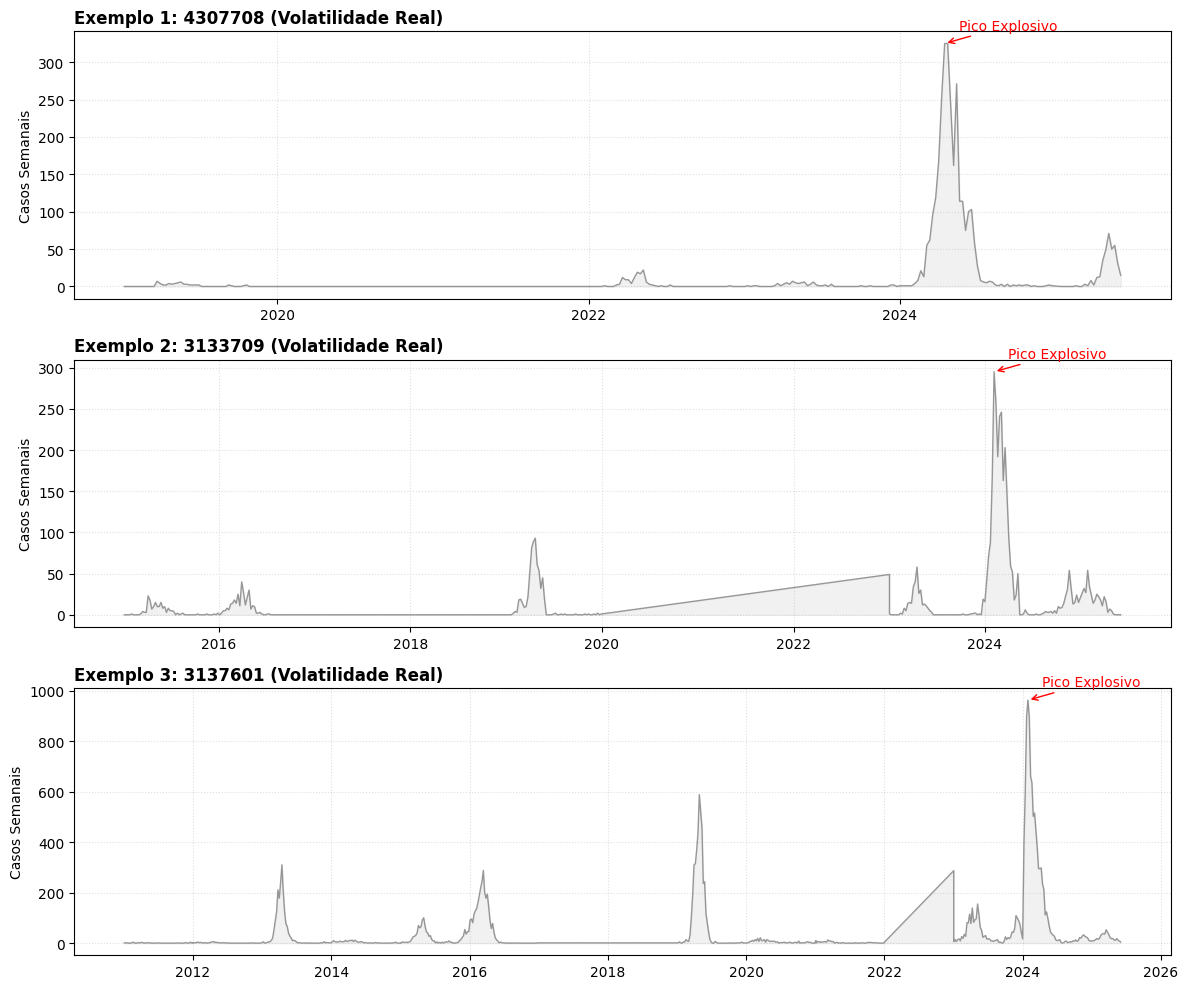

In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
import pandas as pd

def plot_slide2_problem_examples(df, n=3):
    """
    Plota 3 exemplos aleatórios de séries temporais reais de Dengue
    para ilustrar a volatilidade e ruído dos dados (Slide 2).
    """
    # 1. Configuração Estética
    plt.style.use('default') # Garante fundo branco
    fig, axes = plt.subplots(n, 1, figsize=(12, 10), sharex=False, facecolor='white')
    if n == 1: axes = [axes]

    # 2. Selecionar Cidades Aleatórias
    # Filtra apenas cidades com dados suficientes para ficar bonito
    valid_cities = df.groupby('geocode').filter(lambda x: x['casos'].max() > 100)['geocode'].unique()

    if len(valid_cities) < n:
        selected_geocodes = valid_cities
    else:
        selected_geocodes = random.sample(list(valid_cities), n)

    # 3. Plotar
    for i, geocode in enumerate(selected_geocodes):
        ax = axes[i]

        # Filtrar dados da cidade
        city_data = df[df['geocode'] == str(geocode)].sort_values('date')

        # Tenta pegar o nome da cidade se tiver coluna de nome
        city_name = geocode
        if 'geocode_name' in city_data.columns:
            city_name = city_data['geocode_name'].iloc[0]
        elif 'muni_name' in city_data.columns:
            city_name = city_data['muni_name'].iloc[0]

        # Plot da Linha "Ruidosa" (Cinza)
        ax.plot(city_data['date'], city_data['casos'], color='gray', linewidth=1, alpha=0.8, label='Casos Notificados')
        ax.fill_between(city_data['date'], city_data['casos'], color='lightgray', alpha=0.3)

        # Estilização para destacar o "Problema"
        ax.set_title(f"Exemplo {i+1}: {city_name} (Volatilidade Real)", fontsize=12, fontweight='bold', loc='left')
        ax.set_ylabel("Casos Semanais")
        ax.grid(True, linestyle=':', alpha=0.4)

        # Formatar Eixo X
        ax.xaxis.set_major_locator(mdates.YearLocator(2)) # A cada 2 anos
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

        # Adicionar uma anotação de "Ruído" em um pico aleatório para dar ênfase
        if not city_data.empty:
            max_idx = city_data['casos'].idxmax()
            max_date = city_data.loc[max_idx, 'date']
            max_val = city_data.loc[max_idx, 'casos']
            ax.annotate('Pico Explosivo', xy=(max_date, max_val), xytext=(10, 10),
                        textcoords='offset points', arrowprops=dict(arrowstyle="->", color='red'), color='red')

    plt.tight_layout()
    plt.savefig("slide2_problema_dengue.png", dpi=150, facecolor='white')
    plt.show()

# --- EXECUÇÃO ---
# Certifique-se de que 'data_inference' (o dataframe com histórico) está carregado
if 'data_inference' in locals():
    plot_slide2_problem_examples(data_inference)
else:
    print("⚠️ Carregue o dataframe 'data_inference' primeiro (o que tem o histórico completo).")

🗺️ Gerando Mapas Históricos (Mediana 2010-2024)...
✅ Mapa histórico salvo em: resultados_mapas/mapas_historico_real.png


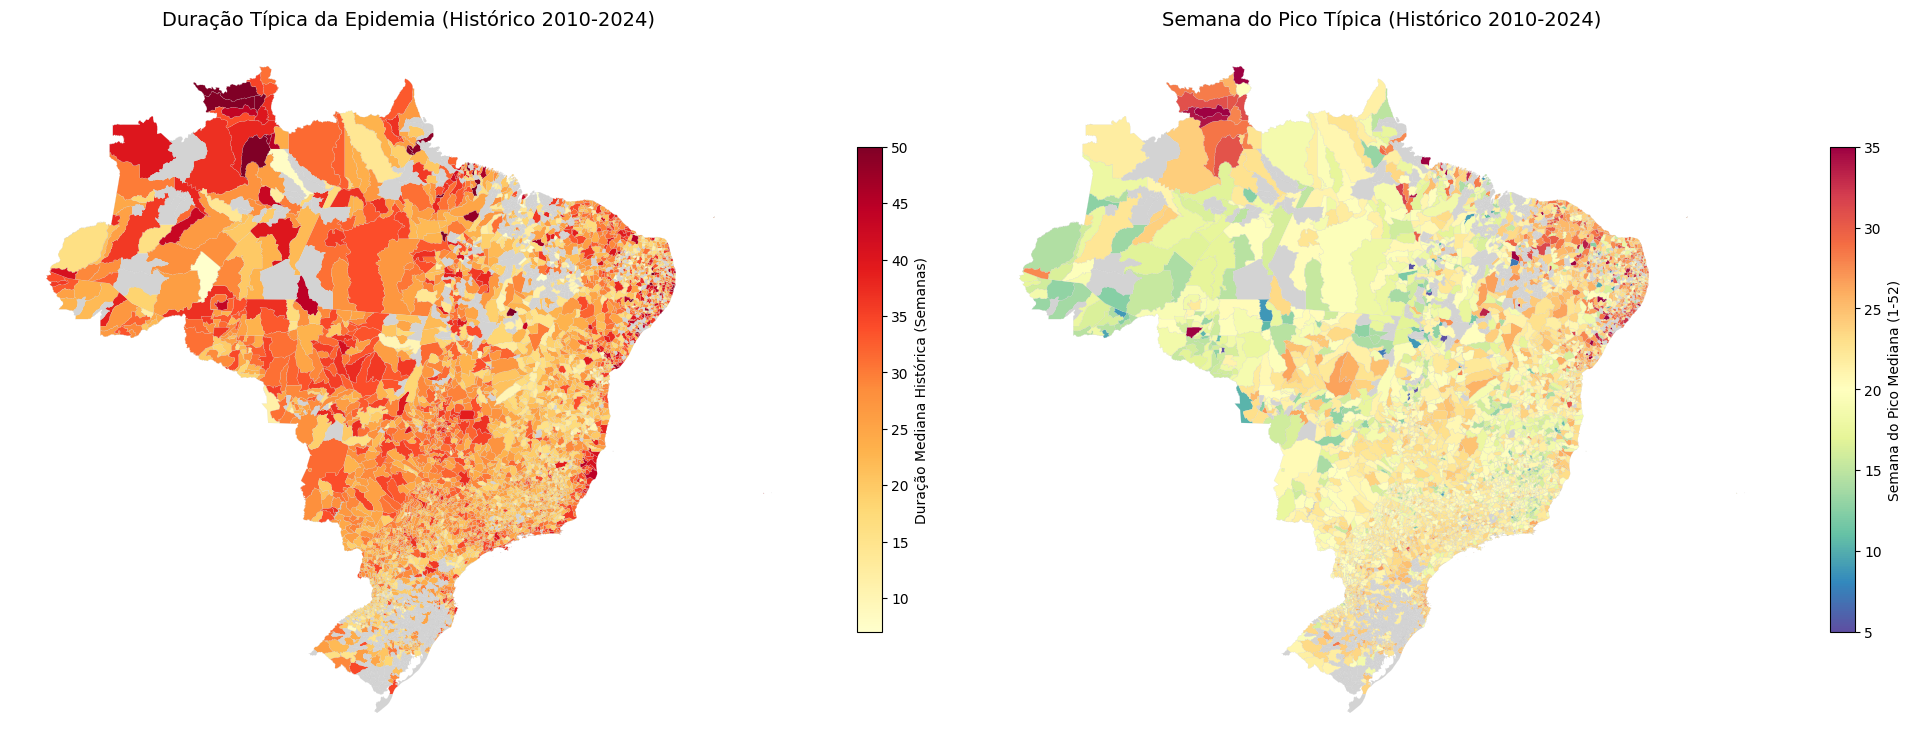

In [38]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_historical_maps(episcanner_path, map_path, save_path=None):
    print("🗺️ Gerando Mapas Históricos (Mediana 2010-2024)...")

    # 1. Carregar Dados Reais (Episcanner)
    try:
        df_epi = pd.read_csv(episcanner_path)
    except FileNotFoundError:
        print(f"❌ Erro: Arquivo {episcanner_path} não encontrado.")
        return

    # 2. Carregar Mapa (Shapefile/Geopackage)
    try:
        gdf_map = gpd.read_file(map_path)
    except FileNotFoundError:
        print(f"❌ Erro: Arquivo de mapa {map_path} não encontrado.")
        return

    # 3. Processamento dos Geocódigos (Padronizar para 6 dígitos para garantir o merge)
    # O IBGE usa 7 dígitos, mas muitas bases usam 6. Cortar o último dígito resolve.
    df_epi['geocode_short'] = df_epi['geocode'].astype(str).str[:6]

    # Tenta achar a coluna de código no mapa (geralmente CD_MUN, CD_GEOCMU, ou geocode)
    map_geo_col = next((c for c in ['geocode', 'CD_MUN', 'CD_GEOCMU', 'code_muni'] if c in gdf_map.columns), None)
    if map_geo_col:
        gdf_map['geocode_short'] = gdf_map[map_geo_col].astype(str).str[:6]
    else:
        print("❌ Não encontrei coluna de código IBGE no mapa.")
        return

    # 4. Cálculo das Medianas Históricas
    # Agrupamos por cidade e pegamos a mediana de todos os anos epidêmicos registrados
    df_history = df_epi.groupby('geocode_short')[['ep_dur', 'peak_week']].median().reset_index()

    # Renomear para ficar claro
    df_history.columns = ['geocode_short', 'Hist_Median_Duration', 'Hist_Median_Peak']

    # 5. Merge com o Mapa
    gdf_final = gdf_map.merge(df_history, on='geocode_short', how='left')

    # Preencher vazios (Cidades que nunca tiveram epidemia no registro) com NaN para ficarem cinza/branco
    # O plot do geopandas lida bem com NaNs (deixa em branco ou cor de fundo)

    # 6. Plotagem (Mesmo estilo do seu código anterior)
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), facecolor='white')

    # Mapa 1: Duração Histórica
    # cmap='YlOrRd' (Amarelo -> Vermelho) igual ao paper
    gdf_final.plot(column='Hist_Median_Duration',
                   cmap='YlOrRd',
                   linewidth=0.1,
                   ax=axes[0],
                   edgecolor='0.8',
                   legend=True,
                   missing_kwds={'color': 'lightgrey', 'label': 'Sem dados/Sem epidemia'},
                   legend_kwds={'label': "Duração Mediana Histórica (Semanas)", 'shrink': 0.5})

    axes[0].set_title("Duração Típica da Epidemia (Histórico 2010-2024)", fontsize=14)
    axes[0].axis('off')

    # Mapa 2: Semana de Pico Histórica
    # cmap='Spectral_r' igual ao paper
    gdf_final.plot(column='Hist_Median_Peak',
                   cmap='Spectral_r',
                   linewidth=0.1,
                   ax=axes[1],
                   edgecolor='0.8',
                   legend=True,
                   missing_kwds={'color': 'lightgrey'},
                   legend_kwds={'label': "Semana do Pico Mediana (1-52)", 'shrink': 0.5})

    axes[1].set_title("Semana do Pico Típica (Histórico 2010-2024)", fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()

    if save_path:
        # Garante diretório
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, facecolor='white')
        print(f"✅ Mapa histórico salvo em: {save_path}")

    plt.show()

# --- CONFIGURAÇÃO E EXECUÇÃO ---
# Ajuste os caminhos se necessário (Ex: /kaggle/input/...)
PATH_EPISCANNER = "../data/raw/data_sprint_2025/dados_episcanner.csv" # Ou o caminho completo
PATH_MAPA = "../data/raw/data_sprint_2025/shape_muni.gpkg"            # Ou o caminho completo

# No Kaggle/Colab, geralmente:
# PATH_EPISCANNER = "/kaggle/input/dengue-dataset/dados_episcanner.csv"
# PATH_MAPA = "/kaggle/input/dengue-dataset/municipios.gpkg"

plot_historical_maps(
    episcanner_path=PATH_EPISCANNER,
    map_path=PATH_MAPA,
    save_path="resultados_mapas/mapas_historico_real.png"
)

In [42]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

def generate_latex_tables(df_real_all, df_preds_all):
    print("📊 Gerando Tabelas Estatísticas...")

    # --- PREPARAÇÃO DOS DADOS ---
    # Merge para alinhar Real e Previsto (Apenas histórico onde temos ambos)
    df_eval = pd.merge(
        df_real_all,
        df_preds_all,
        on=['geocode', 'year'],
        how='inner',
        suffixes=('_real', '_pred')
    )

    # Merge com Regiões (se necessário)
    if 'macroregion_name' not in df_eval.columns:
        try:
            regions = pd.read_csv("../data/raw/data_sprint_2025/map_regional_health.csv") # Ou o caminho correto
            # Garante tipo string
            regions['geocode'] = regions['geocode'].astype(str)
            df_eval['geocode'] = df_eval['geocode'].astype(str)

            df_eval = df_eval.merge(regions[['geocode', 'macroregion_name']], on='geocode', how='left')
        except:
            df_eval['macroregion_name'] = 'Brasil'

    # Funções de Métrica
    def mape(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100

    # ---------------------------------------------------------
    # TABELA 1: PERFORMANCE GLOBAL
    # ---------------------------------------------------------
    # Precisamos dos targets reais do Episcanner para comparar com Pred_R0, Pred_Peak, etc.
    # O df_real_all tem 'casos', mas não tem o R0 real calculado (isso estava no df_episcanner).
    # Vamos assumir que você tem o df_episcanner carregado. Se não, carregamos agora.
    try:
        df_epi = pd.read_csv("../data/raw/data_sprint_2025/dados_episcanner.csv")
        df_epi['geocode'] = df_epi['geocode'].astype(str)

        # Merge com as previsões
        df_metrics = df_preds_all.merge(df_epi, on=['geocode', 'year'], how='inner')

        metrics_data = []

        # Pares (Nome Real, Nome Previsto, Nome Exibição)
        pairs = [
            ('R0', 'Pred_R0', '$R_0$'),
            ('peak_week', 'Pred_Peak', 'Semana Pico'),
            ('total_cases', 'Pred_Total', 'Total Casos')
        ]

        for col_real, col_pred, name in pairs:
            y_true = df_metrics[col_real]
            y_pred = df_metrics[col_pred]

            metrics_data.append({
                "Parâmetro": name,
                "MAE": f"{mean_absolute_error(y_true, y_pred):.2f}",
                "MAPE (%)": f"{mape(y_true, y_pred):.1f}\\%",
                "R²": f"{r2_score(y_true, y_pred):.2f}"
            })

        df_table1 = pd.DataFrame(metrics_data)

        print("\n" + "="*30)
        print("LATEX TABELA 1 (Performance Global):")
        print("="*30)
        print(df_table1.to_latex(index=False, escape=False, column_format="lccc"))

    except Exception as e:
        print(f"⚠️ Não foi possível gerar Tabela 1 (Falta dados reais do Episcanner): {e}")

    # ---------------------------------------------------------
    # TABELA 2: POR REGIÃO
    # ---------------------------------------------------------
    if 'macroregion_name' in df_metrics.columns:
        region_stats = []

        for region, group in df_metrics.groupby('macroregion_name'):
            mae_r0 = mean_absolute_error(group['R0'], group['Pred_R0'])
            mae_peak = mean_absolute_error(group['peak_week'], group['Pred_Peak'])
            count = len(group)

            region_stats.append({
                "Região": region,
                "N (Amostras)": count,
                "MAE ($R_0$)": f"{mae_r0:.2f}",
                "MAE (Pico)": f"{mae_peak:.1f} sem"
            })

        df_table2 = pd.DataFrame(region_stats)

        print("\n" + "="*30)
        print("LATEX TABELA 2 (Por Região):")
        print("="*30)
        print(df_table2.to_latex(index=False, escape=False))

    # ---------------------------------------------------------
    # TABELA 3: TOP RISCO 2026
    # ---------------------------------------------------------
    # Filtrar apenas 2026
    df_2026 = df_preds_all[df_preds_all['year'] == 2026].copy()

    # Adicionar nomes
    if 'geocode_name' not in df_2026.columns:
        # Tenta pegar de algum lugar
        try:
            map_data = pd.read_csv("../data/raw/data_sprint_2025/map_regional_health.csv")
            map_data['geocode'] = map_data['geocode'].astype(str)
            df_2026 = df_2026.merge(map_data[['geocode', 'geocode_name', 'uf']], on='geocode', how='left')
        except:
            pass

    # Ordenar por R0
    top_risk = df_2026.sort_values('Pred_R0', ascending=False).head(10)

    table3_data = top_risk[['geocode_name', 'uf', 'Pred_R0', 'Pred_Peak', 'Pred_Total']].copy()
    table3_data.columns = ['Município', 'UF', 'R0 Previsto', 'Semana Pico', 'Total Est.']

    # Formatação
    table3_data['R0 Previsto'] = table3_data['R0 Previsto'].map('{:.2f}'.format)
    table3_data['Semana Pico'] = table3_data['Semana Pico'].map('{:.1f}'.format)
    table3_data['Total Est.'] = table3_data['Total Est.'].map('{:,.0f}'.format)

    print("\n" + "="*30)
    print("LATEX TABELA 3 (Previsão 2026):")
    print("="*30)
    print(table3_data.to_latex(index=False))

# --- EXECUÇÃO ---
# Certifique-se que df_all_preds e data_inference estao carregados
# E certifique-se que o arquivo 'dados_episcanner.csv' e 'map_regional_health.csv' estao na pasta
try:
    generate_latex_tables(data_inference, all_predictions)
except NameError:
    print("Erro: Dataframes 'data_inference' ou 'df_all_preds' não encontrados na memória.")

📊 Gerando Tabelas Estatísticas...

LATEX TABELA 1 (Performance Global):
\begin{tabular}{lccc}
\toprule
Parâmetro & MAE & MAPE (%) & R² \\
\midrule
$R_0$ & 0.13 & 4.9\% & 0.20 \\
Semana Pico & 3.01 & 13.7\% & 0.52 \\
Total Casos & 13222.70 & 78.5\% & 0.19 \\
\bottomrule
\end{tabular}


LATEX TABELA 3 (Previsão 2026):
\begin{tabular}{llrrr}
\toprule
Município & UF & R0 Previsto & Semana Pico & Total Est. \\
\midrule
\bottomrule
\end{tabular}



🔍 Extraindo pesos de importância da Variable Selection Network (VSN)...

📊 Gerando Gráfico 1: O que importa no PASSADO? (Encoder)
✅ Gráfico salvo: graficos_interpretacao/importancia_encoder.png


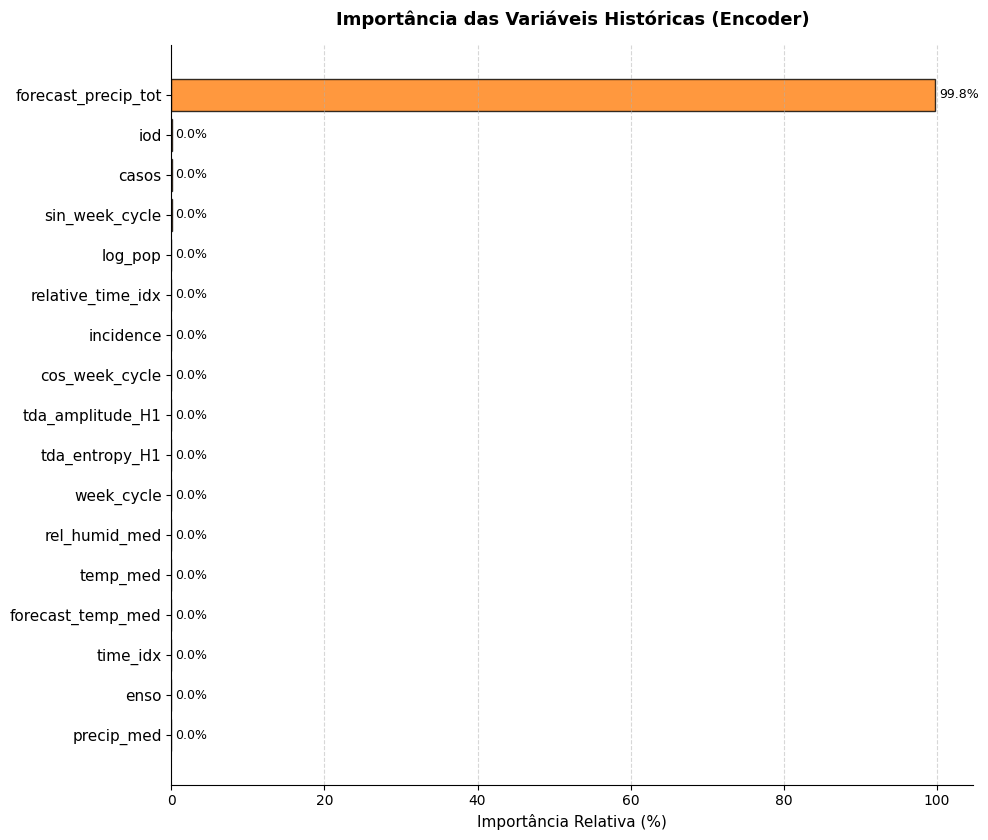


📊 Gerando Gráfico 2: O que importa na GEOGRAFIA? (Static)
✅ Gráfico salvo: graficos_interpretacao/importancia_static.png


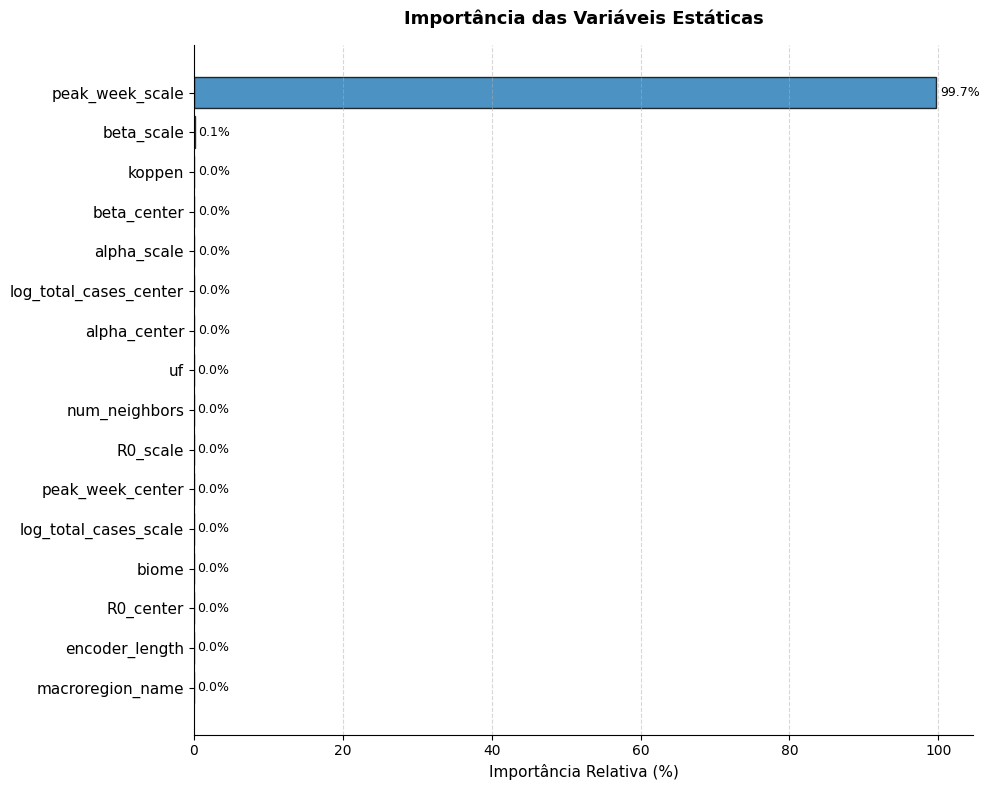


📊 Gerando Gráfico 3: O que importa no FUTURO? (Decoder)
✅ Gráfico salvo: graficos_interpretacao/importancia_decoder.png


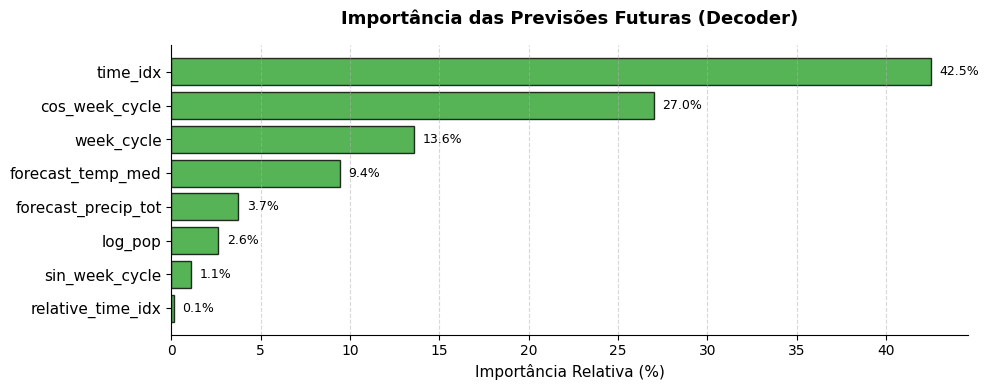

In [43]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

# Garante fundo branco para o relatório
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

def plot_feature_importance_final(model, dataloader, output_folder="graficos_interpretacao"):
    if not os.path.exists(output_folder): os.makedirs(output_folder)

    print("🔍 Extraindo pesos de importância da Variable Selection Network (VSN)...")
    model.eval()

    # 1. Pegar um lote de dados de validação
    try:
        raw_batch = next(iter(dataloader))
        x = raw_batch[0] if isinstance(raw_batch, (list, tuple)) else raw_batch

        # Mover para a mesma device do modelo (GPU ou CPU)
        device = next(model.parameters()).device
        for key in x.keys():
            if hasattr(x[key], "to"):
                x[key] = x[key].to(device)

        # 2. Forward Pass (Pedir para a rede processar e cuspir a interpretação)
        with torch.no_grad():
            raw_output = model(x)

        # Tenta extrair o dicionário de interpretação de várias formas (blindagem contra versões)
        interpretation = None
        if hasattr(raw_output, 'interpretation'):
            interpretation = raw_output.interpretation
        elif isinstance(raw_output, dict) and 'interpretation' in raw_output:
            interpretation = raw_output['interpretation']
        elif hasattr(raw_output, '_asdict'): # NamedTuple
            interpretation = raw_output._asdict().get('interpretation')

        # Se ainda for None, o próprio output pode ser a interpretação (versões novas)
        if interpretation is None:
            interpretation = raw_output

    except Exception as e:
        print(f"❌ Erro técnico ao extrair pesos: {e}")
        return

    # 3. Função de Plotagem das Barras
    def plot_bars(key_name, feature_names, title, color, filename):
        # Tenta pegar os pesos pelo nome da chave (ex: 'encoder_variables')
        tensor_data = None

        if isinstance(interpretation, dict):
            tensor_data = interpretation.get(key_name)
        elif hasattr(interpretation, key_name):
            tensor_data = getattr(interpretation, key_name)

        if tensor_data is None:
            print(f"⚠️ Chave '{key_name}' não encontrada nos pesos.")
            return

        # Processar Tensor (Soma a importância de todos os exemplos e tempos)
        weights = tensor_data.detach().cpu().numpy()

        # Achatar dimensões extras (Batch, Time) -> (Features)
        while weights.ndim > 1:
            weights = weights.sum(axis=0)

        # Normalizar para % (0 a 100)
        total = weights.sum()
        if total > 0: weights = weights / total * 100

        # Fallback se os nomes não baterem com os pesos
        if len(feature_names) != len(weights):
            feature_names = [f"Feat {i}" for i in range(len(weights))]

        # Ordenar (Do mais importante para o menos)
        indices = np.argsort(weights)
        sorted_weights = weights[indices]
        sorted_names = [feature_names[i] for i in indices]

        # --- PLOTAGEM ---
        fig, ax = plt.subplots(figsize=(10, max(4, len(sorted_names) * 0.5)), facecolor='white')

        # Barras
        bars = ax.barh(range(len(sorted_weights)), sorted_weights, color=color, alpha=0.8, edgecolor='black')

        # Eixos e Textos
        ax.set_yticks(range(len(sorted_weights)))
        ax.set_yticklabels(sorted_names, fontsize=11, fontweight='medium', color='black')
        ax.set_xlabel("Importância Relativa (%)", fontsize=11, color='black')
        ax.set_title(title, fontsize=13, fontweight='bold', color='black', pad=15)

        # Valor na ponta da barra
        for rect in bars:
            width = rect.get_width()
            ax.text(width + 0.5, rect.get_y() + rect.get_height()/2,
                    f'{width:.1f}%', ha='left', va='center', fontsize=9, color='black')

        ax.grid(axis='x', linestyle='--', alpha=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.tight_layout()
        save_path = f"{output_folder}/{filename}.png"
        plt.savefig(save_path, dpi=150, facecolor='white')
        print(f"✅ Gráfico salvo: {save_path}")
        plt.show()

    # --- 4. GERAR OS 3 GRÁFICOS PRINCIPAIS ---

    print("\n📊 Gerando Gráfico 1: O que importa no PASSADO? (Encoder)")
    # Procura 'tda_amplitude_H1' aqui!
    plot_bars("encoder_variables", model.encoder_variables,
              "Importância das Variáveis Históricas (Encoder)",
              "#ff7f0e", "importancia_encoder") # Laranja

    print("\n📊 Gerando Gráfico 2: O que importa na GEOGRAFIA? (Static)")
    # Procura 'num_neighbors' aqui!
    plot_bars("static_variables", model.static_variables,
              "Importância das Variáveis Estáticas",
              "#1f77b4", "importancia_static") # Azul

    print("\n📊 Gerando Gráfico 3: O que importa no FUTURO? (Decoder)")
    # Procura 'forecast_temp' aqui!
    plot_bars("decoder_variables", model.decoder_variables,
              "Importância das Previsões Futuras (Decoder)",
              "#2ca02c", "importancia_decoder") # Verde

# --- EXECUÇÃO ---
# Certifique-se de que 'best_tft' e 'val_dataloader' estão na memória
plot_feature_importance_final(best_tft, val_dataloader)

🔍 Gerando Gráficos de Importância (Filtrando Dominantes)...

📊 Gerando Gráficos Filtrados...


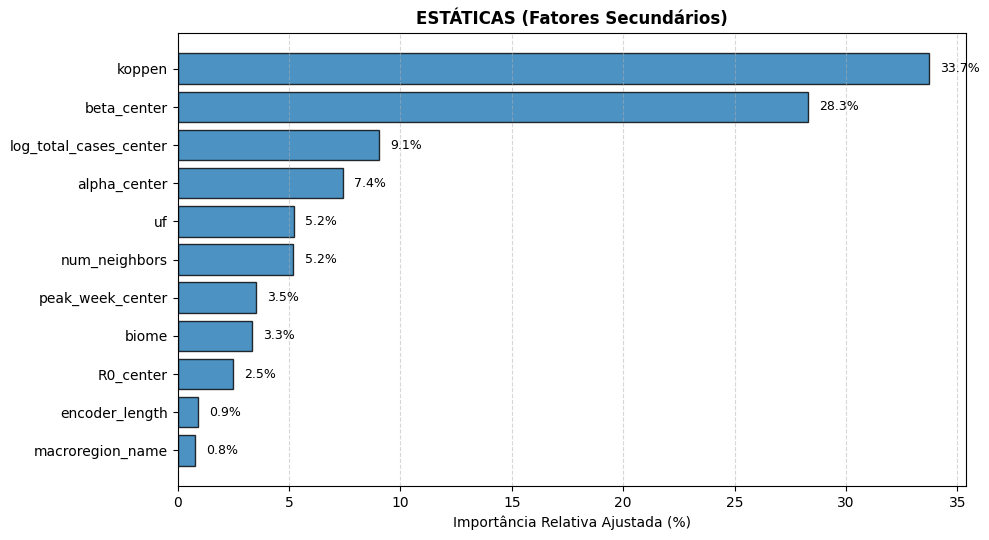

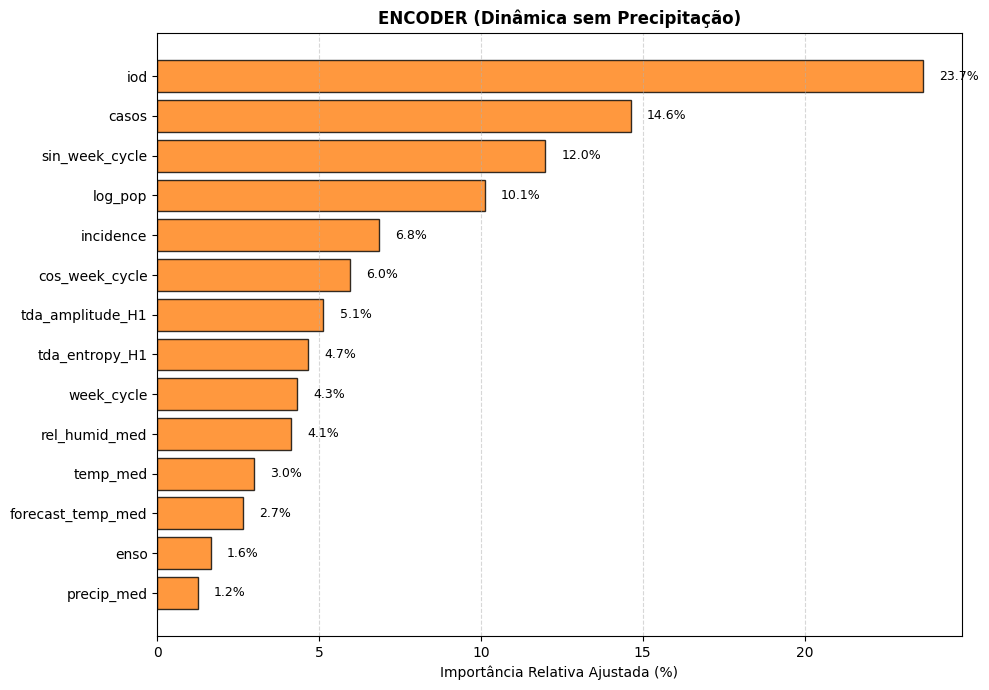

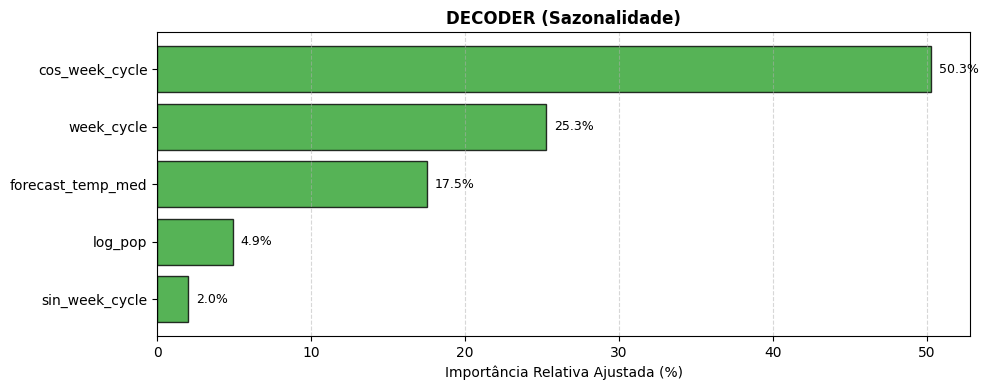

In [45]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_feature_importance_filtered(model, dataloader):
    print("🔍 Gerando Gráficos de Importância (Filtrando Dominantes)...")
    model.eval()

    # 1. Pegar Batch e Extrair Pesos (Igual antes)
    try:
        raw_batch = next(iter(dataloader))
        x = raw_batch[0] if isinstance(raw_batch, (list, tuple)) else raw_batch
        device = model.device
        for key in x.keys():
            if hasattr(x[key], "to"): x[key] = x[key].to(device)
        with torch.no_grad():
            raw_output = model(x)

        # Extração agnóstica
        if hasattr(raw_output, 'to_dict'): interpretation = raw_output.to_dict()
        elif hasattr(raw_output, '_asdict'): interpretation = raw_output._asdict()
        elif isinstance(raw_output, dict): interpretation = raw_output
        else: interpretation = raw_output

    except Exception as e:
        print(f"❌ Erro: {e}")
        return

    # 2. Lista de Variáveis para EXCLUIR (As que roubaram a cena)
    # Adicione aqui tudo que apareceu com 99% nos seus prints
    BLACKLIST = [
        "forecast_precip_tot", # O monstro do Encoder
        "peak_week_scale",     # O monstro Estático
        "log_total_cases_scale",
        "R0_scale",
        "beta_scale",
        "alpha_scale",
        "time_idx",            # O monstro do Decoder
        "relative_time_idx"
    ]

    # 3. Função de Plotagem com Filtro
    def plot_filtered_bars(key_name, feature_names, title, color):
        if isinstance(interpretation, dict):
            if key_name not in interpretation: return
            tensor_data = interpretation[key_name]
        else:
            if not hasattr(interpretation, key_name): return
            tensor_data = getattr(interpretation, key_name)

        # Processar
        weights = tensor_data.detach().cpu().numpy()
        while weights.ndim > 1: weights = weights.sum(axis=0)

        # --- FILTRAGEM ---
        # Criar listas limpas apenas com o que NÃO está na blacklist
        clean_weights = []
        clean_names = []

        for w, name in zip(weights, feature_names):
            if name not in BLACKLIST:
                clean_weights.append(w)
                clean_names.append(name)

        if not clean_weights:
            print(f"⚠️ Todas as variáveis de {title} foram filtradas.")
            return

        clean_weights = np.array(clean_weights)

        # Re-Normalizar para 100% (Zoom nos restantes)
        total = clean_weights.sum()
        if total > 0: clean_weights = clean_weights / total * 100

        # Ordenar
        indices = np.argsort(clean_weights)
        sorted_weights = clean_weights[indices]
        sorted_names = [clean_names[i] for i in indices]

        # Plot
        plt.figure(figsize=(10, max(4, len(sorted_names) * 0.5)), facecolor='white')
        ax = plt.gca()
        ax.set_facecolor('white')

        bars = plt.barh(range(len(sorted_weights)), sorted_weights, color=color, alpha=0.8, edgecolor='black')
        plt.yticks(range(len(sorted_weights)), sorted_names, color='black', fontsize=10)
        plt.xlabel("Importância Relativa Ajustada (%)", color='black')
        plt.title(f"{title}", color='black', fontweight='bold')

        # Valores
        for rect in bars:
            width = rect.get_width()
            plt.text(width + 0.5, rect.get_y() + rect.get_height()/2,
                     f'{width:.1f}%', ha='left', va='center', fontsize=9, color='black')

        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig(f"importancia_filtrada_{key_name}.png", dpi=150, facecolor='white')
        plt.show()

    # --- GERAR ---
    print("\n📊 Gerando Gráficos Filtrados...")
    plot_filtered_bars("static_variables", model.static_variables, "ESTÁTICAS (Fatores Secundários)", "#1f77b4")
    plot_filtered_bars("encoder_variables", model.encoder_variables, "ENCODER (Dinâmica sem Precipitação)", "#ff7f0e")
    plot_filtered_bars("decoder_variables", model.decoder_variables, "DECODER (Sazonalidade)", "#2ca02c")

# Rodar
plot_feature_importance_filtered(best_tft, val_dataloader)